In [308]:
import sys
import sklearn
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import nltk
from nltk.classify.util import accuracy
import matplotlib.cm as cm
# from itertools import cycle
from featx import label_feats_from_corpus, split_label_feats
from nltk.classify.scikitlearn import SklearnClassifier
%matplotlib inline
plt.style.use('ggplot')

## System Information

In [309]:
print('Author: ' + "Lei Yu")
print('Python version ' + sys.version)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('NLTK version: {}.'.format(nltk.__version__))
print('Scikit-learn version: {}.'.format(sklearn.__version__))
print('Default encoding: {}.'.format(sys.getdefaultencoding()))

Author: Lei Yu
Python version 3.6.3 (default, Oct  4 2017, 06:09:15) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
Pandas version: 0.21.0
Matplotlib version: 2.1.1
NLTK version: 3.2.5.
Scikit-learn version: 0.19.1.
Default encoding: utf-8.


In [310]:
print(sys.path)

['', '/Users/ulk510/project/email-attack/tacklebox/lib/python36.zip', '/Users/ulk510/project/email-attack/tacklebox/lib/python3.6', '/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/lib-dynload', '/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/site-packages', '/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/site-packages/IPython/extensions', '/Users/ulk510/.ipython']


In [311]:
import os
print(os.getcwd())

/Users/ulk510/Desktop/cs/text_classification


## ETL (Extract, Transform, Load Data)

In [312]:
from nltk.corpus import PlaintextCorpusReader
# corpus_root = '/Users/yuleinku/Desktop/cs_data/test'
corpus_root = '/Users/ulk510/Desktop/cs/cs_data/test'

wordlists = PlaintextCorpusReader(corpus_root, '.*')
# wordlists.fileids()

In [6]:
# wordlists.sents('001_abid&lal2008SoilTillRes.txt_1.txt')

In [7]:
# wordlists.words('001_abid&lal2008SoilTillRes.txt_1.txt')

In [8]:
# wordlists.paras('001_abid&lal2008SoilTillRes.txt_1.txt')

In [9]:
# wordlists.raw('001_abid&lal2008SoilTillRes.txt_1.txt')

## Preprocessing the dataset into more convenient format

In [313]:
# import pyprind

# basepath = '/Users/yuleinku/Desktop/cs_data/paragraph'
# basepath = '/Users/yuleinku/Desktop/cs_data/section'
basepath = '/Users/ulk510/Desktop/cs/cs_data/section'

labels = {'pos': 1, 'neg': 0}
# pbar = pyprind.ProgBar(2500)
df = pd.DataFrame()
# for s in ('test', 'train'):
#     for l in ('pos', 'neg'):
#         path = os.path.join(basepath, s, l)
#         for file in os.listdir(path):
#             with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
#                 txt = infile.read()
#             df = df.append([[txt, labels[l]]], ignore_index=True)
#             pbar.update()
# df.columns = ['review', 'sentiment']

            
for f in ('pos', 'neg'):
    path = os.path.join(basepath, f)
    for file in os.listdir(path):
        journal = file[:3]
        with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
            txt = infile.read()
        df = df.append([[file, journal, txt, labels[f]]], ignore_index=True)
#         pbar.update()
df.columns = ['File Name', 'Journal', 'Text', 'Label']

In [314]:
import warnings
from bs4 import BeautifulSoup
import re

def clean_text(string): 
    # Turn warnings off because BeautifulSoup give some we don't care about
    warnings.filterwarnings('ignore')
    
    # Remove xml formatting.
#     review_text = BeautifulSoup(string, "lxml").get_text() 
    
    # Turn warnings back on
    warnings.resetwarnings()
    
    # Remove all characters not in the English alphabet
    string = re.sub("[^a-zA-Z]"," ", string)
    
    # Set all characters to lower case.
    string = string.lower()
    
    return string

In [315]:
data = df
data.head()

,File Name,Journal,Text,Label
0,001_abid&lal2008SoilTillRes.txt_0.txt,001,Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil & ...,1
1,001_abid&lal2008SoilTillRes.txt_3.txt,001,\n2. Materials and methods\n\n2.1. Site description\n\nA field experiment was initiated in 1994 ...,1
2,002_abu2013SoilResearch SA.txt_0.txt,002,"CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvaluat...",1
3,002_abu2013SoilResearch SA.txt_3.txt,002,\nMaterials and methods\n\nFive field sites were chosen for the study at the National Animal\nPr...,1
4,002_abu2013SoilResearch SA.txt_4.txt,002,\nResults and discussion\n\nThe AG and BD fields had significantly higher sand content\nthan tho...,1


In [316]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 4 columns):
File Name    1690 non-null object
Journal      1690 non-null object
Text         1690 non-null object
Label        1690 non-null int64
dtypes: int64(1), object(3)
memory usage: 52.9+ KB


In [317]:
data['Clean Text'] = data['Text'].astype(str).apply(clean_text) 

In [318]:
data.head()

,File Name,Journal,Text,Label,Clean Text
0,001_abid&lal2008SoilTillRes.txt_0.txt,001,Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil & ...,1,soil tillage research contents lists available at sciencedirect soil till...
1,001_abid&lal2008SoilTillRes.txt_3.txt,001,\n2. Materials and methods\n\n2.1. Site description\n\nA field experiment was initiated in 1994 ...,1,materials and methods site description a field experiment was initiated in at th...
2,002_abu2013SoilResearch SA.txt_0.txt,002,"CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvaluat...",1,csiro publishing soil research http dx doi org sr evaluating ...
3,002_abu2013SoilResearch SA.txt_3.txt,002,\nMaterials and methods\n\nFive field sites were chosen for the study at the National Animal\nPr...,1,materials and methods five field sites were chosen for the study at the national animal produc...
4,002_abu2013SoilResearch SA.txt_4.txt,002,\nResults and discussion\n\nThe AG and BD fields had significantly higher sand content\nthan tho...,1,results and discussion the ag and bd fields had significantly higher sand content than those o...


In [319]:
from nltk.tokenize import sent_tokenize, word_tokenize

def list_count(list):
    return len(list)

data['Length of Text'] = data['Text'].str.len()
data['tokenized_sents'] = df.apply(lambda row: sent_tokenize(row['Text']), axis=1 )
data['Num of Sent'] = data['tokenized_sents'].apply(list_count)
data['tokenized_words'] = df.apply(lambda row: word_tokenize(row['Text']), axis=1 )
data['Num of Word'] = data['tokenized_words'].apply(list_count)

data['Length of Clean Text'] = data['Clean Text'].str.len()
data['tokenized_sents_clean'] = df.apply(lambda row: sent_tokenize(row['Clean Text']), axis=1 )
data['Num of Sent Clean'] = data['tokenized_sents_clean'].apply(list_count)
data['tokenized_words_clean'] = df.apply(lambda row: word_tokenize(row['Clean Text']), axis=1 )
data['Num of Word Clean'] = data['tokenized_words_clean'].apply(list_count)

data.head()

,File Name,Journal,Text,Label,Clean Text,Length of Text,tokenized_sents,Num of Sent,tokenized_words,Num of Word,Length of Clean Text,tokenized_sents_clean,Num of Sent Clean,tokenized_words_clean,Num of Word Clean
0,001_abid&lal2008SoilTillRes.txt_0.txt,001,Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil & ...,1,soil tillage research contents lists available at sciencedirect soil till...,908,[Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil &...,9,"[Soil, &, Tillage, Research, 100, (, 2008, ), 89-98, Contents, lists, available, at, ScienceDire...",163,908,[soil tillage research contents lists available at sciencedirect soil til...,1,"[soil, tillage, research, contents, lists, available, at, sciencedirect, soil, tillage, research...",116
1,001_abid&lal2008SoilTillRes.txt_3.txt,001,\n2. Materials and methods\n\n2.1. Site description\n\nA field experiment was initiated in 1994 ...,1,materials and methods site description a field experiment was initiated in at th...,5252,"[\n2., Materials and methods\n\n2.1., Site description\n\nA field experiment was initiated in 19...",49,"[2, ., Materials, and, methods, 2.1, ., Site, description, A, field, experiment, was, initiated,...",1047,5252,[ materials and methods site description a field experiment was initiated in at t...,1,"[materials, and, methods, site, description, a, field, experiment, was, initiated, in, at, the, ...",810
2,002_abu2013SoilResearch SA.txt_0.txt,002,"CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvaluat...",1,csiro publishing soil research http dx doi org sr evaluating ...,358,"[CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvalua...",3,"[CSIRO, PUBLISHING, Soil, Research, ,, 2013, ,, 51, ,, 471-476, http, :, //dx.doi.org/10.1071/SR...",59,358,[csiro publishing soil research http dx doi org sr evaluating...,1,"[csiro, publishing, soil, research, http, dx, doi, org, sr, evaluating, long, term, impact, of, ...",49
3,002_abu2013SoilResearch SA.txt_3.txt,002,\nMaterials and methods\n\nFive field sites were chosen for the study at the National Animal\nPr...,1,materials and methods five field sites were chosen for the study at the national animal produc...,4756,[\nMaterials and methods\n\nFive field sites were chosen for the study at the National Animal\nP...,26,"[Materials, and, methods, Five, field, sites, were, chosen, for, the, study, at, the, National, ...",959,4756,[ materials and methods five field sites were chosen for the study at the national animal produ...,1,"[materials, and, methods, five, field, sites, were, chosen, for, the, study, at, the, national, ...",750
4,002_abu2013SoilResearch SA.txt_4.txt,002,\nResults and discussion\n\nThe AG and BD fields had significantly higher sand content\nthan tho...,1,results and discussion the ag and bd fields had significantly higher sand content than those o...,8843,[\nResults and discussion\n\nThe AG and BD fields had significantly higher sand content\nthan th...,72,"[Results, and, discussion, The, AG, and, BD, fields, had, significantly, higher, sand, content, ...",1754,8843,[ results and discussion the ag and bd fields had significantly higher sand content than those ...,1,"[results, and, discussion, the, ag, and, bd, fields, had, significantly, higher, sand, content, ...",1422


In [23]:
# data = data[['File Name', 'Text', 'Length of Text','Num of Sent', 'Num of Word', 'Clean Text',
#                    'Length of Clean Text', 'Num of Sent Clean', 'Num of Word Clean', 'Label']]
# data

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 15 columns):
File Name                1690 non-null object
Journal                  1690 non-null object
Text                     1690 non-null object
Label                    1690 non-null int64
Clean Text               1690 non-null object
Length of Text           1690 non-null int64
tokenized_sents          1690 non-null object
Num of Sent              1690 non-null int64
tokenized_words          1690 non-null object
Num of Word              1690 non-null int64
Length of Clean Text     1690 non-null int64
tokenized_sents_clean    1690 non-null object
Num of Sent Clean        1690 non-null int64
tokenized_words_clean    1690 non-null object
Num of Word Clean        1690 non-null int64
dtypes: int64(7), object(8)
memory usage: 198.1+ KB


In [321]:
data.shape

(1690, 15)

In [322]:
data.describe()

,Label,Length of Text,Num of Sent,Num of Word,Length of Clean Text,Num of Sent Clean,Num of Word Clean
count,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000
mean,0.303550,5368.078107,61.160947,1028.492899,5368.078107,1.0,806.076331
std,0.459927,4885.740731,91.997169,960.321822,4885.740731,0.0,744.289999
min,0.000000,105.000000,1.000000,15.000000,105.000000,1.0,14.000000
25%,0.000000,1267.250000,9.250000,222.250000,1267.250000,1.0,189.500000
50%,0.000000,4169.000000,25.000000,758.500000,4169.000000,1.0,616.500000
75%,1.000000,8301.500000,69.000000,1647.000000,8301.500000,1.0,1258.500000
max,1.000000,29894.000000,589.000000,5631.000000,29894.000000,1.0,4636.000000


## EXPLORATORY ANALYSIS

## Distribution of labels in the dataset

In [323]:
# data.groupby('Label').count()
data['Label'].value_counts(normalize=False)

0    1177
1     513
Name: Label, dtype: int64

In [324]:
data['Label'].value_counts(normalize=True)

0    0.69645
1    0.30355
Name: Label, dtype: float64

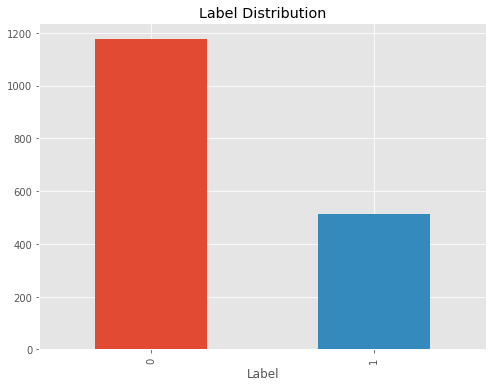

In [325]:
# data.groupby('Label')['File Name'].count().plot(kind='bar',title='Label Distribution',figsize=(10,6))
data.groupby('Label')['File Name'].count().plot(kind='bar',title='Label Distribution',figsize=(8,6))

In [326]:
data.isnull().sum()

File Name                0
Journal                  0
Text                     0
Label                    0
Clean Text               0
Length of Text           0
tokenized_sents          0
Num of Sent              0
tokenized_words          0
Num of Word              0
Length of Clean Text     0
tokenized_sents_clean    0
Num of Sent Clean        0
tokenized_words_clean    0
Num of Word Clean        0
dtype: int64

In [327]:
labels = data['Label']
labels.head()

0    1
1    1
2    1
3    1
4    1
Name: Label, dtype: int64

In [328]:
texts = data['Clean Text']
texts.head()

0    soil   tillage research                   contents lists available at sciencedirect  soil   till...
1        materials and methods       site description  a field experiment was initiated in      at th...
2    csiro publishing soil research                    http   dx doi org         sr       evaluating ...
3     materials and methods  five field sites were chosen for the study at the national animal produc...
4     results and discussion  the ag and bd fields had significantly higher sand content than those o...
Name: Clean Text, dtype: object

count    1690.00
mean      806.04
std       744.26
min        14.00
25%       189.50
50%       616.50
75%      1258.50
max      4636.00
Name: N_words_cleanText, dtype: float64


Text(0,0.5,'Number of Clean Text')

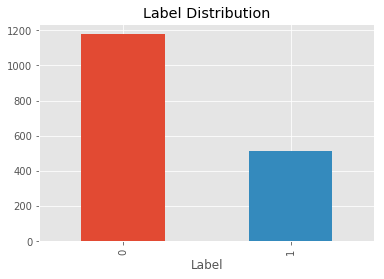

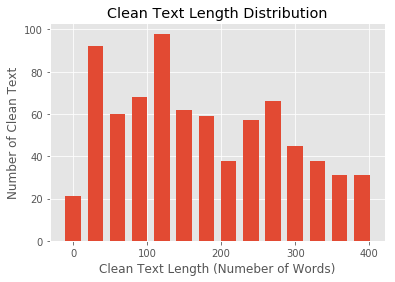

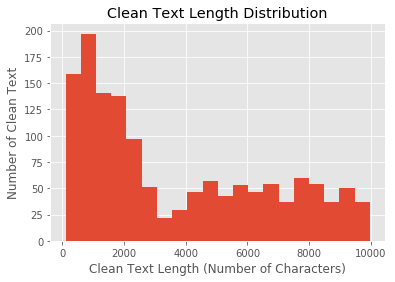

In [440]:
fz = (6,4)
data.groupby('Label')['File Name'].count().plot(kind='bar',title='Label Distribution',figsize=fz)

def countWords(review):
    return(len(review.split()))

data["N_words_cleanText"] = data['Clean Text'].astype(str).apply(countWords)
print(data['N_words_cleanText'].describe().round(2))

bins=range(0,430,30)
a = list(np.clip(data['N_words_cleanText'], 0, 500))
fig, ax = plt.subplots(1,1, figsize=fz)
ax.hist(a, bins=bins, align='left', rwidth=0.7)
plt.title("Clean Text Length Distribution")
plt.xlabel("Clean Text Length (Numeber of Words)")
plt.ylabel("Number of Clean Text")

#### Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data['Clean Text'].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt['Clean Text'] < 10000]
review_length_distribution_plt.groupby(["Clean Text"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', legend=None, bins=20, figsize=fz, title="Clean Text Length Distribution")
review_length_distribution_plt.set_xlabel("Clean Text Length (Number of Characters)")
review_length_distribution_plt.set_ylabel("Number of Clean Text")

Text(0,0.5,'Number of Clean Text')

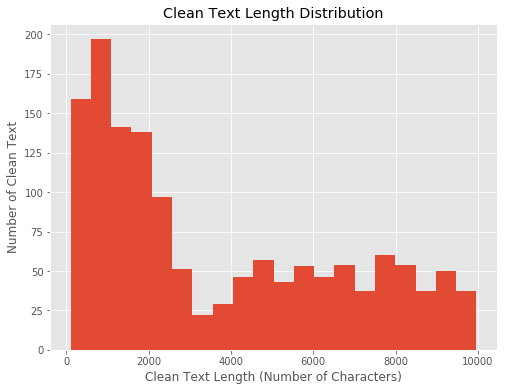

In [337]:
#### Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data['Clean Text'].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt['Clean Text'] < 10000]
review_length_distribution_plt.groupby(["Clean Text"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', legend=None, bins=20, figsize=(8, 6), title="Clean Text Length Distribution")
review_length_distribution_plt.set_xlabel("Clean Text Length (Number of Characters)")
review_length_distribution_plt.set_ylabel("Number of Clean Text")

# Statistical Analysis

The total number of file

The total number of journal

The average file per journal

Number of words per file

Number of words per journal

Number of characters per file

Number of characters per journal


In [247]:
N_file=len(data)
N_journal=len(set(data["Journal"]))
# N_reviewers=len(set(data["reviewerID"]))
print("The total number of file is: "+str(N_file))
print("The total number of journal is: "+str(N_journal))
# print("Total number of reviewers: "+str(N_reviewers))
print("That's an average of "+str(round(N_file/N_journal,1))+ " file per journal")
# print("That's an average of "+str(round(N_reviews/N_reviewers,1))+ " reviews per reviewer")

The total number of file is: 1690
The total number of journal is: 207
That's an average of 8.2 file per journal


In [388]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 17 columns):
File Name                1690 non-null object
Journal                  1690 non-null object
Text                     1690 non-null object
Label                    1690 non-null int64
Clean Text               1690 non-null object
Length of Text           1690 non-null int64
tokenized_sents          1690 non-null object
Num of Sent              1690 non-null int64
tokenized_words          1690 non-null object
Num of Word              1690 non-null int64
Length of Clean Text     1690 non-null int64
tokenized_sents_clean    1690 non-null object
Num of Sent Clean        1690 non-null int64
tokenized_words_clean    1690 non-null object
Num of Word Clean        1690 non-null int64
N_words_cleanText        1690 non-null int64
N_chs_cleanText          1690 non-null int64
dtypes: int64(9), object(8)
memory usage: 224.5+ KB


In [480]:
d_print = data[['File Name', 'Journal', 'Text', 'Label', 'Length of Text', 'Num of Sent', 'Num of Word']]
# d_dict = d_print.to_dict()
a = d_print.set_index('File Name')
# d_print
a

,Journal,Text,Label,Length of Text,Num of Sent,Num of Word
File Name,,,,,,
001_abid&lal2008SoilTillRes.txt_0.txt,001,Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil & ...,1,908,9,163
001_abid&lal2008SoilTillRes.txt_3.txt,001,\n2. Materials and methods\n\n2.1. Site description\n\nA field experiment was initiated in 1994 ...,1,5252,49,1047
002_abu2013SoilResearch SA.txt_0.txt,002,"CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvaluat...",1,358,3,59
002_abu2013SoilResearch SA.txt_3.txt,002,\nMaterials and methods\n\nFive field sites were chosen for the study at the National Animal\nPr...,1,4756,26,959
002_abu2013SoilResearch SA.txt_4.txt,002,\nResults and discussion\n\nThe AG and BD fields had significantly higher sand content\nthan tho...,1,8843,72,1754
002_abu2013SoilResearch SA.txt_5.txt,002,\nConclusions\n\nThe fields under continuous cultivation (CC) exhibited the\nhighest bulk densit...,1,1707,9,322
003_acosta-martinez.etal2003BiolFertilSoils.txt_0.txt,003,Biol Fertil Soils (2003) 38:216-227\nDOI 10.1007/s00374-003-0626-1\n\nORIGINAL PAPER\n\nV. Acost...,1,1026,3,180
003_acosta-martinez.etal2003BiolFertilSoils.txt_3.txt,003,\nMaterials and methods\n\nSoil sampling and sites description\n\nSamples were taken in January ...,1,7204,47,1382
003_acosta-martinez.etal2003BiolFertilSoils.txt_4.txt,003,"\nResults and discussion\n\nSoil enzyme activities\n\nA plot of the activities of b-glucosidase,...",1,13346,92,2456


In [481]:
print( a.to_latex() )

\begin{tabular}{lllrrrr}
\toprule
{} & Journal &                                                                                                 Text &  Label &  Length of Text &  Num of Sent &  Num of Word \\
File Name                                                                                            &         &                                                                                                      &        &                 &              &              \\
\midrule
001\_abid\&lal2008SoilTillRes.txt\_0.txt                                                                &     001 &  Soil \& Tillage Research 100 (2008) 89-98\textbackslashn\textbackslashnContents lists available at ScienceDirect\textbackslashn\textbackslashnSoil \& ... &      1 &             908 &            9 &          163 \\
001\_abid\&lal2008SoilTillRes.txt\_3.txt                                                                &     001 &  \textbackslashn2. Materials and methods\textbackslashn\text

In [368]:
data["N_chs_cleanText"] = data['Clean Text'].str.len()
print(N_file)
print(N_journal)
# print(data["N_chs_cleanText"].describe().round(2))
# print(data["N_chs_cleanText"].mean())
# print(data['N_words_cleanText'].describe().round(2))
# print(data['N_words_cleanText'].mean())

print(data.groupby('Label')['File Name'].count())
data.head(3)

1690
207
Label
0    1177
1     513
Name: File Name, dtype: int64


,File Name,Journal,Text,Label,Clean Text,Length of Text,tokenized_sents,Num of Sent,tokenized_words,Num of Word,Length of Clean Text,tokenized_sents_clean,Num of Sent Clean,tokenized_words_clean,Num of Word Clean,N_words_cleanText,N_chs_cleanText
0,001_abid&lal2008SoilTillRes.txt_0.txt,001,Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil & ...,1,soil tillage research contents lists available at sciencedirect soil till...,908,[Soil & Tillage Research 100 (2008) 89-98\n\nContents lists available at ScienceDirect\n\nSoil &...,9,"[Soil, &, Tillage, Research, 100, (, 2008, ), 89-98, Contents, lists, available, at, ScienceDire...",163,908,[soil tillage research contents lists available at sciencedirect soil til...,1,"[soil, tillage, research, contents, lists, available, at, sciencedirect, soil, tillage, research...",116,116,908
1,001_abid&lal2008SoilTillRes.txt_3.txt,001,\n2. Materials and methods\n\n2.1. Site description\n\nA field experiment was initiated in 1994 ...,1,materials and methods site description a field experiment was initiated in at th...,5252,"[\n2., Materials and methods\n\n2.1., Site description\n\nA field experiment was initiated in 19...",49,"[2, ., Materials, and, methods, 2.1, ., Site, description, A, field, experiment, was, initiated,...",1047,5252,[ materials and methods site description a field experiment was initiated in at t...,1,"[materials, and, methods, site, description, a, field, experiment, was, initiated, in, at, the, ...",810,810,5252
2,002_abu2013SoilResearch SA.txt_0.txt,002,"CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvaluat...",1,csiro publishing soil research http dx doi org sr evaluating ...,358,"[CSIRO PUBLISHING\nSoil Research, 2013, 51, 471-476\nhttp://dx.doi.org/10.1071/SR12360\n\nEvalua...",3,"[CSIRO, PUBLISHING, Soil, Research, ,, 2013, ,, 51, ,, 471-476, http, :, //dx.doi.org/10.1071/SR...",59,358,[csiro publishing soil research http dx doi org sr evaluating...,1,"[csiro, publishing, soil, research, http, dx, doi, org, sr, evaluating, long, term, impact, of, ...",49,49,358


# groupby()

The output from a groupby and aggregation operation varies between 

Pandas Series and Pandas Dataframes, which can be confusing for new users. 

As a rule of thumb, if you calculate more than one column of results, 

your result will be a Dataframe. For a single column of results, 

the agg function, by default, will produce a Series.

https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [396]:
# You can change this by selecting your operation column differently:

A = data.groupby('Journal')['N_words_cleanText'].sum() # produces Pandas Series
B = data.groupby('Journal')[['N_words_cleanText']].sum() # Produces Pandas DataFrame
type(A), type(B)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [393]:
# How many entries are there for N_words_cleanText if 'Label'==1 ?
data['N_words_cleanText'][data['Label']==1].count()

# How many words in cleanText are recorded in total if 'Label'==1 ?
data['N_words_cleanText'][data['Label']==1].sum()

# How many entries are there for each Journal?
data['Journal'].value_counts()

# Number of non-null unique Journal entries
data['Journal'].nunique()

data.groupby(['Journal']).groups.keys()
len(data.groupby(['Journal']).groups['001'])

# Get the first entry for each Journal
data.groupby('Journal').first()

# Get the sum of the number of words in CleanText per Journal
data.groupby('Journal')['N_words_cleanText'].sum()

# Get the number of Files / entries in each Journal
data.groupby('Journal')['File Name'].count()

# What is the sum of the number of words in CleanText, for Lable==1 only, to each Journal
data[data['Label'] == 1].groupby('Journal')['N_words_cleanText'].sum()

# How many calls, sms, and data entries are in each month?
# data.groupby(['month', 'item'])['date'].count()

data.groupby(['Journal', 'Label'])['N_words_cleanText'].count()
data.groupby(['Journal', 'Label'])['N_words_cleanText'].sum()

Journal  Label
001      0        5047
         1         926
002      0        1677
         1        2471
003      0        1901
         1        3311
004      0        3912
         1        2876
005      0        4532
         1        2754
006      0        4731
         1        1557
007      0        5096
         1        2848
008      0        5652
         1        3323
009      0        2240
         1        3104
010      0        3094
         1        3120
011      0        3858
         1        3948
012      0        3412
         1         826
013      0        6204
         1        1357
014      0        4853
         1        1380
015      0        2980
         1        3412
                  ... 
195      0        4755
         1        1271
196      0        6489
         1        1983
197      0        2828
         1        2550
198      0        3594
         1        1390
199      0        3529
         1        3821
200      0        2808
         1        7

# agg()

Instructions for aggregation are provided in the form of a python dictionary or list. 

The dictionary keys are used to specify the columns upon which you’d like to 

perform operations, and the dictionary values to specify the function to run.


In [445]:
# Group the data frame by month and item and extract a number of stats from each group
data.groupby(['Journal', 'Label']).agg({'N_chs_cleanText':sum,      # find the sum of the durations for each group
                                     'File Name': "count", # find the number of network type entries
                                     'N_words_cleanText': 'first'})    # get the first date per group

# Group the data frame by month and item and extract a number of stats from each group
# Define the aggregation calculations
aggregations = {'File Name': "count", # find the number of network type entries
                'N_chs_cleanText': [min, max, sum, 'mean'],      # find the min, max, and sum of the duration column
                'N_words_cleanText': [min, max, sum, 'mean']  # Rounds mean to nearest integer, e.g. 1.95 = 2 and 1.05 = 1
#                 'N_words_cleanText': [min, 'first', 'nunique']
               }

# Perform groupby aggregation by "month", but only on the rows that are of type "call"
table_stat = data.groupby(['Journal', 'Label']).agg(aggregations).astype(int)    # get the min, first, and number 
table_stat

File Name N_chs_cleanText                       \
                  count             min    max    sum   mean   
Journal Label                                                  
001     0             5             304  17013  33326   6665   
        1             2             908   5252   6160   3080   
002     0             3            1500   7808  12343   4114   
        1             4             358   8843  15664   3916   
003     0             4             269   6096  13492   3373   
        1             3            1026  13346  21576   7192   
004     0             4            1946  11662  27082   6770   
        1             3             881  12224  18897   6299   
005     0             6             445  11785  30407   5067   
        1             3            1068   9210  17231   5743   
006     0             5            1632  12590  32196   6439   
        1             3             999   7181  10601   3533   
007     0             5            1586  13553  35590   7118   
        1             3            1283  11657  19356   6452   
008     0             6             272  13216  37674   6279   
        1             3             948  13629  21122   7040   
009     0             4            1181   7708  14787   3696   
        1             3            1146  11211  20238   6746   
010     0             4             370   9737  21497   5374   
        1             4             598   9540  20372   5093   
011     0             6             380  12610  25598   4266   
        1             3            1095  15699  24699   8233   
012     0             6             441   7025  22556   3759   
        1             2             293   4976   5269   2634   
013     0             6             907  14938  40985   6830   
        1             2            1021   8360   9381   4690   
014     0             6             303  17107  33301   5550   
        1             2            1000   8264   9264   4632   
015     0             4            2589   8886  20386   5096   
        1             3             471  13086  21863   7287   
...                 ...             ...    ...    ...    ...   
195     0             6             302  14073  31491   5248   
        1             2             839   7656   8495   4247   
196     0             7             523  13429  45082   6440   
        1             2            1164  12109  13273   6636   
197     0             5            1158  10066  19589   3917   
        1             3             551   8058  16577   5525   
198     0             5            1718   7351  24174   4834   
        1             2            1824   7404   9228   4614   
199     0             5             274   9836  22237   4447   
        1             3             843  11827  23727   7909   
200     0             5             245  10875  19824   3964   
        1             3             517  28868  49888  16629   
201     0             6             134  12278  24682   4113   
        1             2             716   5270   5986   2993   
202     0             5            1846   3809  13843   2768   
        1             2             547   2987   3534   1767   
203     0             7             290   9817  36065   5152   
        1             2            1027   9205  10232   5116   
204     0             7             205  14175  41254   5893   
        1             2            1062  11125  12187   6093   
205     0             5             781  16294  32047   6409   
        1             3            1198  16533  29138   9712   
206     0             6             590   9420  23472   3912   
        1             2            1099   5585   6684   3342   
207     0             6             322  11784  26340   4390   
        1             3            1025   8075  12463   4154   
208     0             6             596  21589  45293   7548   
        1             2            1377  10012  11389   5694   
209     0             6             470  11141

In [446]:
print( table_stat.to_latex() )

\begin{tabular}{llrrrrrrrrr}
\toprule
    &   & File Name & \multicolumn{4}{l}{N\_chs\_cleanText} & \multicolumn{4}{l}{N\_words\_cleanText} \\
    &   &     count &             min &    max &    sum &   mean &               min &   max &   sum &  mean \\
Journal & Label &           &                 &        &        &        &                   &       &       &       \\
\midrule
001 & 0 &         5 &             304 &  17013 &  33326 &   6665 &                42 &  2648 &  5047 &  1009 \\
    & 1 &         2 &             908 &   5252 &   6160 &   3080 &               116 &   810 &   926 &   463 \\
002 & 0 &         3 &            1500 &   7808 &  12343 &   4114 &               212 &  1035 &  1677 &   559 \\
    & 1 &         4 &             358 &   8843 &  15664 &   3916 &                49 &  1422 &  2471 &   617 \\
003 & 0 &         4 &             269 &   6096 &  13492 &   3373 &                33 &   835 &  1901 &   475 \\
    & 1 &         3 &            1026 &  13346 &  21576 

In [26]:
t = data.groupby('Label').agg(['mean', 'count'])
t

Length of Text       Num of Sent        Num of Word        \
                mean count        mean count         mean count   
Label                                                             
0        5182.564996  1177   69.348343  1177   996.745115  1177   
1        5793.709552   513   42.376218   513  1101.333333   513   

      Length of Clean Text       Num of Sent Clean       Num of Word Clean  \
                      mean count              mean count              mean   
Label                                                                        
0              5182.564996  1177                 1  1177        772.987256   
1              5793.709552   513                 1   513        881.994152   

            N_words_cleanText        
      count              mean count  
Label                                
0      1177        772.948173  1177  
1       513        881.968811   513

In [27]:
print(type(t))
p = t['Length of Text']['count'][1]
n = t['Length of Text']['count'][0]
print('Number of positive samples is {} ({}%)'.format(p, p/N_file * 100))
print('Number of negative samples is {} ({}%)'.format(n, n/N_file * 100))

<class 'pandas.core.frame.DataFrame'>
Number of positive samples is 513 (30.355029585798814%)
Number of negative samples is 1177 (69.64497041420118%)


# How bag-of-words model work

### Transforming documents into feature vectors

In [229]:
from sklearn.feature_extraction.text import CountVectorizer
import operator

count = CountVectorizer()
# count = CountVectorizer(ngram_range=(2,2))
# docs = np.array([
#         'The sun is shining',
#         'The weather is sweet',
#         'The sun is shining, the weather is sweet, and one and one is two'])

docs = np.array([
        'Statistical analysis of the data',
    
        'Materials and methods',
    
        'Soil sampling, processing and analysis',
    
        'Soil Research',
    
        'Soil & Tillage Research'])

print(type(texts))
# docs = texts[:2]
bag = count.fit_transform(docs)
print(count.vocabulary_)
print(type(count.vocabulary_))
x = count.vocabulary_
orted_x = sorted(x.items(), key=operator.itemgetter(1))
print(orted_x)
print(bag.toarray())

<class 'pandas.core.series.Series'>
{'statistical': 10, 'analysis': 0, 'of': 5, 'the': 11, 'data': 2, 'materials': 3, 'and': 1, 'methods': 4, 'soil': 9, 'sampling': 8, 'processing': 6, 'research': 7, 'tillage': 12}
<class 'dict'>
[('analysis', 0), ('and', 1), ('data', 2), ('materials', 3), ('methods', 4), ('of', 5), ('processing', 6), ('research', 7), ('sampling', 8), ('soil', 9), ('statistical', 10), ('the', 11), ('tillage', 12)]
[[1 0 1 0 0 1 0 0 0 0 1 1 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 1]]


In [231]:
mat = bag.toarray()
print(type(mat))
print(mat[:,0])
print(type(orted_x))
header = [x for x,_ in orted_x]
print(header)
file_name = ['File1','File2','File3','File4','File5']
# # col = [mat[:, header.index(h)] for h in header]
# col = [mat[file_name.index(f),:] for f in file_name]
# print(type(col))
# print(col)
# # x = dict.fromkeys(range(0, 10), 0)
# # result = [{
# #     h : pd.Series(mat[:,header.index(h)], index=file_name),
# # } for h in header]
# ind = pd.Series(col, index=header)
# result = dict.fromkeys( header, pd.Series(col) )
# # print(tb)
# print(ind)
# # print(result)
# result = pd.DataFrame(result)
# result
col = [[]]
# for n in range(len(header)):
#     print(n)
#     col[n] = [mat[file_name.index(f),n] for f in file_name]
# [col[h] [mat[file_name.index(f),h] for f in file_name] for h in len(header)]
# print(col_1)

<class 'numpy.ndarray'>
[1 0 1 0 0]
<class 'list'>
['analysis', 'and', 'data', 'materials', 'methods', 'of', 'processing', 'research', 'sampling', 'soil', 'statistical', 'the', 'tillage']


In [30]:
# model_name =["Logistic Regression", "Logistic Regression FT", "SVM", "SVM FT", 'Decision Tree',
#              'Decision Tree FT', 'Linear Regression', 'Naive Bayes', 'KNN','Bagging', 'Boosting', 'Majority Voting']

# predicted = [predicted_lr, predicted_lr_ft, predicted_svc, predicted_svc_ft, predicted_dt, predicted_dt_ft, 
#              predicted_reg,predicted_nb, predicted_knn,predicted_bag,predicted_ada, predicted_mv_clf]



# Accuracy = [percent_round(np.mean(x==y_test)) for x in predicted]
# Report = [sklearn.metrics.precision_recall_fscore_support(y_test, x) for x in predicted]
# Precision = [percent_round(x[0][1]) for x in Report]
# Recall = [percent_round(x[1][1]) for x in Report]
# f1score = [percent_round(x[2][1]) for x in Report]
# result = {'Accuracy' : pd.Series(Accuracy, index=model_name),
#            'Precision' : pd.Series(Precision, index=model_name),
#            'Recall' : pd.Series(Recall, index=model_name),
#            'f1-score': pd.Series(f1score, index=model_name),
#            }
# df_bin = pd.DataFrame(result)
# df_bin

# How TF-IDF work

### Assessing word relevancy via term frequency-inverse document frequency

In [31]:
np.set_printoptions(precision=2)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs))
      .toarray())

[[ 0.37  0.    0.46  0.    0.    0.46  0.    0.    0.    0.    0.46  0.46
   0.  ]
 [ 0.    0.5   0.    0.61  0.61  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.42  0.42  0.    0.    0.    0.    0.52  0.    0.52  0.35  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.77  0.    0.64  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.56  0.    0.46  0.    0.
   0.69]]


# Train Data and Test Data Split

In [28]:
data.columns.values

array(['File Name', 'Journal', 'Text', 'Label', 'Clean Text',
       'Length of Text', 'tokenized_sents', 'Num of Sent',
       'tokenized_words', 'Num of Word', 'Length of Clean Text',
       'tokenized_sents_clean', 'Num of Sent Clean',
       'tokenized_words_clean', 'Num of Word Clean', 'N_words_cleanText'], dtype=object)

In [29]:
data = data[['Label', 'Journal', 'File Name', 
               'Clean Text', 'Length of Clean Text',
               'tokenized_sents_clean', 'Num of Sent Clean', 'tokenized_words_clean', 'Num of Word Clean',
               'Text', 'Length of Text',
               'tokenized_sents', 'Num of Sent', 'tokenized_words', 'Num of Word',]]

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 15 columns):
Label                    1690 non-null int64
Journal                  1690 non-null object
File Name                1690 non-null object
Clean Text               1690 non-null object
Length of Clean Text     1690 non-null int64
tokenized_sents_clean    1690 non-null object
Num of Sent Clean        1690 non-null int64
tokenized_words_clean    1690 non-null object
Num of Word Clean        1690 non-null int64
Text                     1690 non-null object
Length of Text           1690 non-null int64
tokenized_sents          1690 non-null object
Num of Sent              1690 non-null int64
tokenized_words          1690 non-null object
Num of Word              1690 non-null int64
dtypes: int64(7), object(8)
memory usage: 198.1+ KB


In [32]:
data.head(2)

,Label,Journal,File Name,Clean Text,Length of Clean Text,tokenized_sents_clean,Num of Sent Clean,tokenized_words_clean,Num of Word Clean,Text,Length of Text,tokenized_sents,Num of Sent,tokenized_words,Num of Word
0,1,001,001_abid&lal2008SoilTillRes.txt_0.txt,soil tillage research cont...,908,[soil tillage research con...,1,"[soil, tillage, research, contents, lists, ava...",116,Soil & Tillage Research 100 (2008) 89-98\n\nCo...,908,[Soil & Tillage Research 100 (2008) 89-98\n\nC...,9,"[Soil, &, Tillage, Research, 100, (, 2008, ), ...",163
1,1,001,001_abid&lal2008SoilTillRes.txt_3.txt,materials and methods site descripti...,5252,[ materials and methods site descript...,1,"[materials, and, methods, site, description, a...",810,\n2. Materials and methods\n\n2.1. Site descri...,5252,"[\n2., Materials and methods\n\n2.1., Site des...",49,"[2, ., Materials, and, methods, 2.1, ., Site, ...",1047


In [33]:
# X_train = df.loc[:25000, 'review'].values
# y_train = df.loc[:25000, 'sentiment'].values
# X_test = df.loc[25000:, 'review'].values
# y_test = df.loc[25000:, 'sentiment'].values

from sklearn.model_selection import train_test_split

y = data["Label"]
X = data.drop("Label",axis=1,inplace=False)
# X = data["Clean Text"]
X_train,X_test,y_train,y_test = train_test_split(X.index, y, test_size=0.25, stratify=y)

df_train = pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test = pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test
# print(data.head(2))
# print(df_train.shape, df_test.shape)
# print(df_train.head(2))

In [34]:
del X, y, X_train, X_test

In [36]:
df_train.head(2)

,Journal,File Name,Clean Text,Length of Clean Text,tokenized_sents_clean,Num of Sent Clean,tokenized_words_clean,Num of Word Clean,Text,Length of Text,tokenized_sents,Num of Sent,tokenized_words,Num of Word,Label
726,038,038_culman.etal2013AgronJ.txt_6.txt,acknowledgments we would like to acknowledge...,425,[ acknowledgments we would like to acknowledg...,1,"[acknowledgments, we, would, like, to, acknowl...",65,\nAcknowledgments\n\nWe would like to acknowle...,425,[\nAcknowledgments\n\nWe would like to acknowl...,3,"[Acknowledgments, We, would, like, to, acknowl...",74,0
586,015,"015_Bell and Raczkowski, 2007 SA.txt_6.txt",references mueller j p barbercheck m e...,8886,[ references mueller j p barbercheck m ...,1,"[references, mueller, j, p, barbercheck, m, e,...",1270,"\nReferences\n\n1 Mueller, J.P., Barbercheck, ...",8886,"[\nReferences\n\n1 Mueller, J.P., Barbercheck,...",259,"[References, 1, Mueller, ,, J.P., ,, Barberche...",1810,0


In [37]:
X_train = df_train["Clean Text"]
X_test = df_test["Clean Text"]

Train Data:
  count    1267.00
mean        0.30
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Label, dtype: float64

Test Data:
  count    423.00
mean       0.30
std        0.46
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: Label, dtype: float64


Text(0,0.5,'Count')

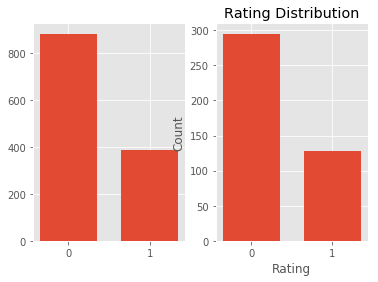

In [38]:
print('Train Data:\n ',df_train["Label"].describe().round(2))
a=[int(i) for i in df_train["Label"]]
bins=range(0,3)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(a, bins=bins, align='left', rwidth=0.7)
ax1.set_xticks(bins[:-1])
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")

print('\nTest Data:\n ', df_test["Label"].describe().round(2))
a=[int(i) for i in df_test["Label"]]
bins=range(0,3)
ax2.hist(a, bins=bins, align='left', rwidth=0.7)
ax2.set_xticks(bins[:-1])
plt.xlabel("Rating")
plt.ylabel("Count")

# Machine Learning Classifiers Using Scikit-Learn

Training machine learning model for document classification

# Logistic Regression

In [39]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

### Fine-tuning machine learning models via grid search

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords

stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.1, 1.0, 10.0, 100.0]},
              
              {'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.1, 1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

# Determines the cross-validation splitting strategy. Possible inputs for cv are:
# None, to use the default 3-fold cross validation,
# integer, to specify the number of folds in a (Stratified)KFold,
# For integer/None inputs, 
# if the estimator is a classifier and y is either binary or multiclass, 
# StratifiedKFold is used. In all other cases, KFold is used.

# By setting n_jobs=-1, we can use all available CPUs on our machine to do the computation in parallel.

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ulk510/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [41]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 30.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 2)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', '...f': [False], 'vect__norm': [None], 'clf__penalty': ['l1', 'l2'], 'clf__C': [0.1, 1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_tr

In [42]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x11b28b840>} 
CV Accuracy: 0.952


In [43]:
lr_ft = gs_lr_tfidf.best_estimator_
print('Test AUC: %.3f' % lr_ft.score(X_test, y_test))

Test AUC: 0.910


In [45]:
from sklearn.metrics import accuracy_score

y_train_pred = lr_ft.predict(X_train)
y_test_pred = lr_ft.predict(X_test)

lr_ft_train = accuracy_score(y_train, y_train_pred) 
lr_ft_test = accuracy_score(y_test, y_test_pred) 
print('Logistic Regression FT train/test AUC %.3f/%.3f'
      % (lr_ft_train, lr_ft_test))

Logistic Regression FT train/test AUC 0.993/0.910


In [46]:
lr = lr_tfidf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % lr.score(X_test, y_test))

Test Accuracy: 0.915


In [47]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

lr_train = accuracy_score(y_train, y_train_pred) 
lr_test = accuracy_score(y_test, y_test_pred) 
print('Logistic Regression train/test accuracies %.3f/%.3f'
      % (lr_train, lr_test))

Logistic Regression train/test accuracies 0.930/0.915


In [43]:
# tfidf = TfidfVectorizer( min_df=2, max_df=0.95, ngram_range = (1,3), 
#                              stop_words = 'english', max_features = 500 )

# param_grid = [{'vect__ngram_range': [(1, 1)],
#                'vect__stop_words': [stop, None],
#                'vect__tokenizer': [tokenizer, tokenizer_porter],
#                'clf__penalty': ['l1', 'l2'],
#                'clf__C': [1.0, 10.0, 100.0]},
              
#               {'vect__ngram_range': [(1, 1)],
#                'vect__stop_words': [stop, None],
#                'vect__tokenizer': [tokenizer, tokenizer_porter],
#                'vect__use_idf':[False],
#                'vect__norm':[None],
#                'clf__penalty': ['l1', 'l2'],
#                'clf__C': [1.0, 10.0, 100.0]},
#               ]

# lr_tfidf = Pipeline([('vect', tfidf),
#                      ('clf', LogisticRegression(random_state=0))])

# gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
#                            scoring='accuracy',
#                            cv=5,
#                            verbose=1,
#                            n_jobs=-1)

# gs_lr_tfidf.fit(X_train, y_train)
# print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
# print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)
# clf = gs_lr_tfidf.best_estimator_
# print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

# Support Vector Machine

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)


# pipe_svc = make_pipeline(StandardScaler(),
#                          SVC(random_state=1))

# pipe_svc = Pipeline([('vect', tfidf), ('clf', SVC(random_state=1))])
pipe_svc = make_pipeline( tfidf, SVC(probability=True,random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__kernel': ['linear', 'rbf'],
               'clf__C': param_range}
              ]

svc_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SVC(probability=True,random_state=1))])


gs_svc_tfidf = GridSearchCV(svc_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# param_grid = [{'svc__C': param_range, 
#                'svc__kernel': ['linear']},
              
#               {'svc__C': param_range, 
#                'svc__gamma': param_range, 
#                'svc__kernel': ['rbf']}]

# gs = GridSearchCV(estimator=pipe_svc, 
#                   param_grid=param_grid, 
#                   scoring='roc_auc', 
#                   verbose=1,
#                   cv=5,
#                   n_jobs=-1)

/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ulk510/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [49]:
gs_svc = gs_svc_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 51.5min finished


In [50]:
print('Best parameter set: %s ' % gs_svc.best_params_)
print('CV Accuracy: %.3f' % gs_svc.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__kernel': 'linear', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x11b28b840>} 
CV Accuracy: 0.942


In [52]:
svc_ft = gs_svc.best_estimator_
# svc_ft.fit(X_train, y_train)
print('Test accuracy: %.3f' % svc_ft.score(X_test, y_test))

Test accuracy: 0.908


In [53]:
y_train_pred = svc_ft.predict(X_train)
y_test_pred = svc_ft.predict(X_test)

svc_ft_train = accuracy_score(y_train, y_train_pred) 
svc_ft_test = accuracy_score(y_test, y_test_pred) 
print('SVM FT train/test accuracies %.3f/%.3f'
      % (svc_ft_train, svc_ft_test))

SVM FT train/test accuracies 0.994/0.908


### NO Fine-tuning

In [54]:
svc = svc_tfidf.fit(X_train, y_train)
print('Test accuracy: %.3f' % svc.score(X_test, y_test))

Test accuracy: 0.697


In [55]:
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

svc_train = accuracy_score(y_train, y_train_pred) 
svc_test = accuracy_score(y_test, y_test_pred) 
print('SVM train/test accuracies %.3f/%.3f'
      % (svc_train, svc_test))

SVM train/test accuracies 0.696/0.697


# Decision Tree

In [ ]:
stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.1, 1.0, 10.0, 100.0]},
              
              {'vect__ngram_range': [(1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.1, 1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [182]:
from sklearn.tree import DecisionTreeClassifier

# pipe_dt = make_pipeline( tfidf, DecisionTreeClassifier(random_state=1) )
dt_tfidf = Pipeline([('vect', tfidf), ('clf', DecisionTreeClassifier(random_state=1))])

param_grid = {'vect__ngram_range': [(1, 2)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer, tokenizer_porter],
              'clf__max_depth': np.arange(1, 30, 2),
#               "clf__min_samples_split": np.arange(10,50,10),
#               "clf__min_samples_leaf": np.arange(10,50,10),
#               "clf__max_leaf_nodes": np.arange(1,30,5),
#               'clf__class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
#               "clf__criterion": ["gini", "entropy"]
             }

gs_dt_tfidf = GridSearchCV(dt_tfidf, 
                  param_grid, 
                  scoring = 'roc_auc', 
                  verbose = 1,
                  cv = 5,
                  n_jobs = -1)

In [184]:
gs_dt = gs_dt_tfidf.fit(X_train, y_train)

In [80]:
print('Best parameter set: %s ' % gs_dt.best_params_)
print('CV Accuracy: %.3f' % gs_dt.best_score_)

Best parameter set: {'clf__max_depth': 5, 'vect__ngram_range': (1, 2), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',

In [82]:
dt_ft = gs_dt.best_estimator_
# dt_ft.fit(X_train, y_train)
print('Test accuracy: %.3f' % dt_ft.score(X_test, y_test))

Test accuracy: 0.903


In [83]:
y_train_pred = dt_ft.predict(X_train)
y_test_pred = dt_ft.predict(X_test)

dt_ft_train = accuracy_score(y_train, y_train_pred) 
dt_ft_test = accuracy_score(y_test, y_test_pred) 
print('Decision Tree FT train/test accuracies %.3f/%.3f'
      % (dt_ft_train, dt_ft_test))

Decision Tree FT train/test accuracies 0.929/0.903


### NO Fine-tuning

In [84]:
dt = dt_tfidf.fit(X_train, y_train)
print('Test accuracy: %.3f' % dt.score(X_test, y_test))

Test accuracy: 0.887


In [85]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

dt_train = accuracy_score(y_train, y_train_pred) 
dt_test = accuracy_score(y_test, y_test_pred) 
print('Decision Tree train/test accuracies %.3f/%.3f'
      % (dt_train, dt_test))

Decision Tree train/test accuracies 0.994/0.887


# Naive Bayes

In [99]:
from sklearn.naive_bayes import MultinomialNB
# MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

nb_tfidf = Pipeline(steps= [('vect', tfidf), 
                              ('clf', MultinomialNB() )])

param_grid = {
              'vect__ngram_range': [(1, 3)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer, tokenizer_porter],
              "clf__alpha": np.arange(0.1, 3, 0.1),
              "clf__fit_prior": [True, False],
             }

gs_nb_tfidf = GridSearchCV(estimator = nb_tfidf, 
                  param_grid = param_grid, 
                  scoring = 'roc_auc', 
                  verbose = 1,
                  cv = 5,
                  n_jobs = -1)

In [100]:
gs_nb = gs_nb_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 232 candidates, totalling 1160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 83.6min
[Parallel(n_jobs=-1)]: Done 1160 out of 1160 | elapsed: 123.3min finished


In [101]:
print('Best parameter set: %s ' % gs_nb.best_params_)
print('CV Accuracy: %.3f' % gs_nb.best_score_)

Best parameter set: {'clf__alpha': 0.10000000000000001, 'clf__fit_prior': True, 'vect__ngram_range': (1, 3), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'suc

In [102]:
nb_ft = gs_nb.best_estimator_
print('Test AUC: %.3f' % nb_ft.score(X_test, y_test))

Test AUC: 0.896


In [103]:
y_train_pred = nb_ft.predict(X_train)
y_test_pred = nb_ft.predict(X_test)

nb_ft_train = accuracy_score(y_train, y_train_pred) 
nb_ft_test = accuracy_score(y_test, y_test_pred) 
print('Naive Bayes train/test accuracies %.3f/%.3f'
      % (nb_ft_train, nb_ft_test))

Naive Bayes train/test accuracies 0.973/0.896


### NO Fine-tuning

In [104]:
nb = nb_tfidf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % lr.score(X_test, y_test))

Test Accuracy: 0.915


In [105]:
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

nb_train = accuracy_score(y_train, y_train_pred) 
nb_test = accuracy_score(y_test, y_test_pred) 
print('Logistic Regression train/test accuracies %.3f/%.3f'
      % (nb_train, nb_test))

Logistic Regression train/test accuracies 0.805/0.785


# K Nearest Neighbors

In [113]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, 
#                      algorithm=’auto’, leaf_size=30, p=2, 
#                      metric=’minkowski’, 
#                      metric_params=None, n_jobs=1, **kwargs)

param_grid = {
              'vect__ngram_range': [(1, 2)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer, tokenizer_porter],
    
#               "clf__n_neighbors": np.arange(1, 6, 2),
              "clf__leaf_size": np.arange(10, 20, 5),
              "clf__p": [1, 2],
              "clf__metric": ['minkowski'],
             }

knn_tfidf = Pipeline(steps= [('vect', tfidf), 
                              ('clf', KNeighborsClassifier() )])

gs_knn_tfidf = GridSearchCV(estimator = knn_tfidf, 
                  param_grid = param_grid, 
                  scoring = 'roc_auc', 
                  verbose = 1,
                  cv = 5,
                  n_jobs = -1)

In [114]:
gs_knn = gs_knn_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 85.0min finished


In [115]:
print('Best parameter set: %s ' % gs_knn.best_params_)
print('CV Accuracy: %.3f' % gs_knn.best_score_)

Best parameter set: {'clf__leaf_size': 10, 'clf__metric': 'minkowski', 'clf__p': 2, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x11b28b840>} 
CV Accuracy: 0.917


In [116]:
knn_ft = gs_knn.best_estimator_
print('Test AUC: %.3f' % knn_ft.score(X_test, y_test))

Test AUC: 0.882


In [117]:
y_train_pred = knn_ft.predict(X_train)
y_test_pred = knn_ft.predict(X_test)

knn_ft_train = accuracy_score(y_train, y_train_pred) 
knn_ft_test = accuracy_score(y_test, y_test_pred) 
print('KNN train/test accuracies %.3f/%.3f'
      % (knn_ft_train, knn_ft_test))

KNN train/test accuracies 0.918/0.882


### NO Fine-tuning

In [118]:
knn = knn_tfidf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % knn.score(X_test, y_test))

Test Accuracy: 0.884


In [119]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

knn_train = accuracy_score(y_train, y_train_pred) 
knn_test = accuracy_score(y_test, y_test_pred) 
print('Logistic Regression train/test accuracies %.3f/%.3f'
      % (knn_train, knn_test))

Logistic Regression train/test accuracies 0.919/0.884


# Applying bagging to classify samples in the dataset

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_bag = Pipeline(steps= [('vect', tfidf), 
                              ('clf', DecisionTreeClassifier(criterion='entropy', 
                                      max_depth=None,
                                      random_state=1) )])

bag = BaggingClassifier(base_estimator=tree_bag,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False,
                        verbose=1,
                        n_jobs=-1, 
                        random_state=1)


/Users/yuleinku/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [58]:
bag = tree_bag
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Bagging train/test accuracies 0.993/0.863


In [197]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier(n_estimators=10, criterion=’gini’, 
#                        max_depth=None, min_samples_split=2, 
#                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                        max_features=’auto’, max_leaf_nodes=None, 
#                        min_impurity_decrease=0.0, 
#                        min_impurity_split=None, bootstrap=True, 
#                        oob_score=False, n_jobs=1, 
#                        random_state=None, verbose=0, 
#                        warm_start=False, class_weight=None)

param_grid = {
              'vect__ngram_range': [(1, 2)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer, tokenizer_porter],
              "clf__n_estimators": np.arange(10, 150, 50),
              "clf__max_depth": np.arange(1, 20, 8),
              "clf__min_samples_split": np.arange(10,100,50),
              "clf__min_samples_leaf": np.arange(10,100,50),
              "clf__max_leaf_nodes": np.arange(10,30,10),
              'clf__class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
              "clf__bootstrap": [True, False],
              "clf__criterion": ["gini", "entropy"]
             }

rf_tfidf = Pipeline([('vect', tfidf), ('clf', RandomForestClassifier(random_state=1))])

gs_rf_tfidf = GridSearchCV(estimator = rf_tfidf, 
                  param_grid = param_grid, 
                  scoring = 'roc_auc', 
                  verbose = 1,
                  cv = 5,
                  n_jobs = -1)

In [198]:
gs_rf = gs_rf_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 66.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 105.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 151.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 206.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 269.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 341.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 421.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 509.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 606.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 711.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 824.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 947.0min
[Parallel(n_jobs=-1)]: Done 12784 tasks      | 

In [199]:
print('Best parameter set: %s ' % gs_rf.best_params_)
print('CV Accuracy: %.3f' % gs_rf.best_score_)

Best parameter set: {'clf__bootstrap': False, 'clf__class_weight': {0: 1, 1: 1}, 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__max_leaf_nodes': 20, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 60, 'clf__n_estimators': 110, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x11b28b840>} 
CV Accuracy: 0.960


In [200]:
rf_ft = gs_rf.best_estimator_
print('Test accuracy: %.3f' % rf_ft.score(X_test, y_test))

Test accuracy: 0.894


In [201]:
y_train_pred = rf_ft.predict(X_train)
y_test_pred = rf_ft.predict(X_test)

rf_ft_train = accuracy_score(y_train, y_train_pred) 
rf_ft_test = accuracy_score(y_test, y_test_pred) 
print('SVM FT train/test accuracies %.3f/%.3f'
      % (rf_ft_train, rf_ft_test))

SVM FT train/test accuracies 0.903/0.894


### NO Fine-tuning

In [202]:
rf = rf_tfidf.fit(X_train, y_train)
print('Test accuracy: %.3f' % rf.score(X_test, y_test))

Test accuracy: 0.901


In [203]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

rf_train = accuracy_score(y_train, y_train_pred) 
rf_test = accuracy_score(y_test, y_test_pred) 
print('SVM train/test accuracies %.3f/%.3f'
      % (rf_train, rf_test))

SVM train/test accuracies 0.984/0.901


# Applying AdaBoost using scikit-learn

In [59]:
from sklearn.ensemble import AdaBoostClassifier

# tree_ada = DecisionTreeClassifier(criterion='entropy', 
#                               max_depth=1,
#                               random_state=1)

tree_ada = Pipeline(steps= [('vect', tfidf), 
                              ('clf', DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1) )])

ada = AdaBoostClassifier(base_estimator=tree_ada,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

# ada = ada.fit(X_train, y_train)
tree_ada = tree_ada.fit(X_train, y_train)

In [60]:
ada = tree_ada
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

AdaBoost train/test accuracies 0.800/0.790


In [204]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoostClassifier(base_estimator=None, n_estimators=50, 
#                    learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)

param_grid = {
              'vect__ngram_range': [(1, 2)],
              'vect__stop_words': [stop, None],
              'vect__tokenizer': [tokenizer, tokenizer_porter],
              "clf__n_estimators": np.arange(10, 150, 20),
              "clf__learning_rate": np.arange(0.1, 2, 0.1),
#               "clf__min_samples_split": np.arange(10,150,50),
#               "clf__min_samples_leaf": np.arange(10,150,50),
#               "clf__max_leaf_nodes": np.arange(10,30,5),
#               'clf__class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
#               "clf__criterion": ["gini", "entropy"]
             }

ada_tfidf = Pipeline([('vect', tfidf), ('clf', AdaBoostClassifier(random_state=1))])

gs_ada_tfidf = GridSearchCV(estimator = ada_tfidf, 
                  param_grid = param_grid, 
                  scoring = 'roc_auc', 
                  verbose = 1,
                  cv = 5,
                  n_jobs = -1)

In [205]:
gs_ada = gs_ada_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 532 candidates, totalling 2660 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 84.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 134.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 194.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 264.8min
[Parallel(n_jobs=-1)]: Done 2660 out of 2660 | elapsed: 290.5min finished


In [206]:
print('Best parameter set: %s ' % gs_ada.best_params_)
print('CV Accuracy: %.3f' % gs_ada.best_score_)

Best parameter set: {'clf__learning_rate': 0.10000000000000001, 'clf__n_estimators': 70, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x11b28b840>} 
CV Accuracy: 0.948


In [207]:
ada_ft = gs_ada.best_estimator_
print('Test accuracy: %.3f' % ada_ft.score(X_test, y_test))

Test accuracy: 0.908


In [425]:
y_train_pred = ada_ft.predict(X_train)
y_test_pred = ada_ft.predict(X_test)

ada_ft_train = accuracy_score(y_train, y_train_pred) 
ada_ft_test = accuracy_score(y_test, y_test_pred) 
print('SVM FT train/test accuracies %.3f/%.3f'
      % (ada_ft_train, ada_ft_test))

SVM FT train/test accuracies 0.928/0.908


### NO Fine-tuning

In [209]:
ada = ada_tfidf.fit(X_train, y_train)
print('Test accuracy: %.3f' % ada.score(X_test, y_test))

Test accuracy: 0.898


In [210]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('SVM train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

SVM train/test accuracies 0.971/0.898


# Topic modeling

### Decomposing text documents with Latent Dirichlet Allocation

### Latent Dirichlet Allocation with scikit-learn

In [61]:
count = CountVectorizer(stop_words='english',
                        max_df=.1,
                        max_features=5000)
# X = count.fit_transform(data['Clean Text'].values)
X_train = count.fit_transform(df_train['Clean Text'].values)

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=2,
                                random_state=123,
                                learning_method='batch')
# X_topics = lda.fit_transform(X)
X_topics = lda.fit_transform(X_train)

/Users/yuleinku/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [63]:
lda.components_.shape

(2, 5000)

In [64]:
n_top_words = 5
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
pom compost cotton wsa mbc
Topic 2:
stover pp biol res eds


# Save Models

In [ ]:
# Save to file in the current working directory
pkl_filename = "gbm_model.pkl"
alg = clf

with open(pkl_filename, 'wb') as file:  
    pickle.dump(alg, file)

In [65]:
import numpy as np

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [ ]:
with open('data_feature.pkl', 'rb') as file:
    f = pickle.load(file)

# Combining Different Models for Ensemble Learning

In [146]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.pipeline import _name_estimators
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [432]:
from sklearn.model_selection import cross_val_score

# del X_train, X_test
# X_train = df_train["Clean Text"]
# X_test = df_test["Clean Text"]

clf_labels =["Logistic Regression FT", "SVM FT", 'Decision Tree FT',
             'Naive Bayes FT', 'KNN FT','Bagging (RF FT)', 'Boosting (Ada FT)']


print('5-fold cross validation:\n')
for clf, label in zip([lr_ft, svc_ft, dt_ft, nb_ft, knn_ft, rf_ft, ada_ft], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=-1,
                             verbose=1,                             
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))


for clf, label in zip(all_clf, clf_labels):
    y_score = clf.predict(X_train)
    score = roc_auc_score(y_train, y_score)
    acc = accuracy_score(y_train, y_score)
    print("Train ROC AUC: %0.3f, Accuracy: %0.3f [%s]"
          % (score, acc, label))
    
    y_score = clf.predict(X_test)
    score = roc_auc_score(y_test, y_score)
    acc = accuracy_score(y_test, y_score)
    print("Test ROC AUC: %0.3f, Accuracy: %0.3f [%s]"
          % (score, acc, label))

10-fold cross validation:



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.2s finished


ROC AUC: 0.952 (+/- 0.020) [Logistic Regression FT]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   48.9s remaining:   32.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


ROC AUC: 0.941 (+/- 0.021) [SVM FT]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.3s finished


ROC AUC: 0.875 (+/- 0.052) [Decision Tree FT]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   52.2s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


ROC AUC: 0.925 (+/- 0.042) [Naive Bayes FT]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.2s finished


ROC AUC: 0.906 (+/- 0.041) [KNN FT]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.0s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.5s finished


ROC AUC: 0.955 (+/- 0.020) [Bagging (RF FT)]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   24.2s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.3s finished


ROC AUC: 0.947 (+/- 0.035) [Boosting (Ada FT)]
Train ROC AUC: 0.989, Accuracy: 0.993 [Logistic Regression FT]
Test ROC AUC: 0.869, Accuracy: 0.910 [Logistic Regression FT]
Train ROC AUC: 0.990, Accuracy: 0.994 [SVM FT]
Test ROC AUC: 0.868, Accuracy: 0.908 [SVM FT]
Train ROC AUC: 0.883, Accuracy: 0.929 [Decision Tree FT]
Test ROC AUC: 0.851, Accuracy: 0.903 [Decision Tree FT]
Train ROC AUC: 0.957, Accuracy: 0.973 [Naive Bayes FT]
Test ROC AUC: 0.841, Accuracy: 0.896 [Naive Bayes FT]
Train ROC AUC: 0.886, Accuracy: 0.918 [KNN FT]
Test ROC AUC: 0.836, Accuracy: 0.882 [KNN FT]
Train ROC AUC: 0.842, Accuracy: 0.903 [Bagging (RF FT)]
Test ROC AUC: 0.826, Accuracy: 0.894 [Bagging (RF FT)]
Train ROC AUC: 0.885, Accuracy: 0.928 [Boosting (Ada FT)]
Test ROC AUC: 0.857, Accuracy: 0.908 [Boosting (Ada FT)]


In [433]:
# Majority Rule (hard) Voting
from sklearn.metrics import roc_auc_score

clf_labels =["Logistic Regression FT", "SVM FT", 'Decision Tree FT',
             'Naive Bayes FT', 'KNN FT','Bagging (RF FT)', 'Boosting (Ada FT)']
mv_clf = MajorityVoteClassifier(classifiers=[lr_ft, svc_ft, dt_ft, nb_ft, knn_ft, rf_ft, ada_ft])
clf_labels += ['Majority voting']
all_clf = [lr_ft, svc_ft, dt_ft, nb_ft, knn_ft, rf_ft, ada_ft, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=-1,
                             verbose=1,
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))
    
#     y_score = clf.predict(X_train)
#     score = roc_auc_score(y_train, y_score)
#     acc = accuracy_score(y_train, y_score)
#     print("Train ROC AUC: %0.3f, Accuracy: %0.3f [%s]"
#           % (score, acc, label))
    
#     y_score = clf.predict(X_test)
#     score = roc_auc_score(y_test, y_score)
#     acc = accuracy_score(y_test, y_score)
#     print("Test ROC AUC: %0.3f, Accuracy: %0.3f [%s]"
#           % (score, acc, label))



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


ROC AUC: 0.952 (+/- 0.015) [Logistic Regression FT]
Train ROC AUC: 0.989, Accuracy: 0.993 [Logistic Regression FT]
Test ROC AUC: 0.869, Accuracy: 0.910 [Logistic Regression FT]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.2s remaining:   42.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


ROC AUC: 0.942 (+/- 0.015) [SVM FT]
Train ROC AUC: 0.990, Accuracy: 0.994 [SVM FT]
Test ROC AUC: 0.868, Accuracy: 0.908 [SVM FT]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


ROC AUC: 0.891 (+/- 0.016) [Decision Tree FT]
Train ROC AUC: 0.883, Accuracy: 0.929 [Decision Tree FT]
Test ROC AUC: 0.851, Accuracy: 0.903 [Decision Tree FT]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.0s remaining:   57.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.1s finished


ROC AUC: 0.929 (+/- 0.025) [Naive Bayes FT]
Train ROC AUC: 0.957, Accuracy: 0.973 [Naive Bayes FT]
Test ROC AUC: 0.841, Accuracy: 0.896 [Naive Bayes FT]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


ROC AUC: 0.917 (+/- 0.022) [KNN FT]
Train ROC AUC: 0.886, Accuracy: 0.918 [KNN FT]
Test ROC AUC: 0.836, Accuracy: 0.882 [KNN FT]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


ROC AUC: 0.960 (+/- 0.013) [Bagging (RF FT)]
Train ROC AUC: 0.842, Accuracy: 0.903 [Bagging (RF FT)]
Test ROC AUC: 0.826, Accuracy: 0.894 [Bagging (RF FT)]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.1s remaining:   27.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


ROC AUC: 0.948 (+/- 0.019) [Boosting (Ada FT)]
Train ROC AUC: 0.885, Accuracy: 0.928 [Boosting (Ada FT)]
Test ROC AUC: 0.857, Accuracy: 0.908 [Boosting (Ada FT)]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min


ROC AUC: 0.960 (+/- 0.012) [Majority voting]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


AttributeError: 'MajorityVoteClassifier' object has no attribute 'classifiers_'

# CM Plot Function

In [213]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    rcParams['figure.figsize'] = 10, 20
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.savefig('cm.png')
    plt.show()

# Performance Evaluation Metrics

In [70]:
# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % 0.79)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random guessing')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

Train ROC AUC: 0.989, Accuracy: 0.993 [Logistic Regression FT]
Test ROC AUC: 0.869, Accuracy: 0.910 [Logistic Regression FT]
Train ROC AUC: 0.990, Accuracy: 0.994 [SVM FT]
Test ROC AUC: 0.868, Accuracy: 0.908 [SVM FT]
Train ROC AUC: 0.883, Accuracy: 0.929 [Decision Tree FT]
Test ROC AUC: 0.851, Accuracy: 0.903 [Decision Tree FT]
Train ROC AUC: 0.957, Accuracy: 0.973 [Naive Bayes FT]
Test ROC AUC: 0.841, Accuracy: 0.896 [Naive Bayes FT]
Train ROC AUC: 0.886, Accuracy: 0.918 [KNN FT]
Test ROC AUC: 0.836, Accuracy: 0.882 [KNN FT]
Train ROC AUC: 0.842, Accuracy: 0.903 [Bagging (RF FT)]
Test ROC AUC: 0.826, Accuracy: 0.894 [Bagging (RF FT)]
Train ROC AUC: 0.885, Accuracy: 0.928 [Boosting (Ada FT)]
Test ROC AUC: 0.857, Accuracy: 0.908 [Boosting (Ada FT)]
Train ROC AUC: 0.918, Accuracy: 0.949 [Majority voting]
Test ROC AUC: 0.870, Accuracy: 0.917 [Majority voting]


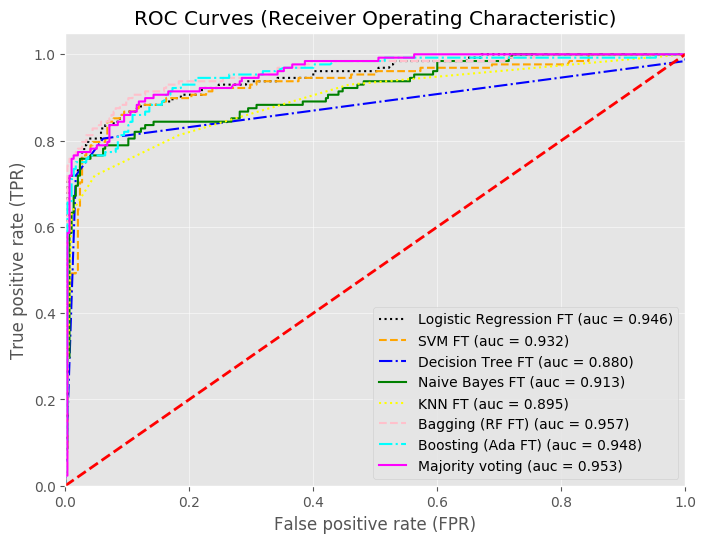

In [434]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue',  'green','yellow','pink','cyan','magenta',   'purple']
linestyles = [':', '--', '-.', '-',  ':', '--', '-.', '-', ':', '--', '-.', '-']

#define plot size in inches (width, height) & resolution(DPI)
# fig = plt.figure(figsize=(4, 5), dpi=100)
fig = plt.figure(figsize=(8, 6), dpi=100)

for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
#     y_pred = clf.predict_proba(X_test)[:, 1]   
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))
    
    y_score = clf.predict(X_train)
    score = roc_auc_score(y_train, y_score)
    acc = accuracy_score(y_train, y_score)
    print("Train ROC AUC: %0.3f, Accuracy: %0.3f [%s]"
          % (score, acc, label))
    
    y_score = clf.predict(X_test)
    score = roc_auc_score(y_test, y_score)
    acc = accuracy_score(y_test, y_score)
    print("Test ROC AUC: %0.3f, Accuracy: %0.3f [%s]"
          % (score, acc, label))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='red',
         label='random guessing',
         linewidth=2)

# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curves (Receiver Operating Characteristic)')


plt.savefig('images/roc_sec', dpi=300)
# plt.show()

In [439]:
# lr_ft, svc_ft, dt_ft, mv_clf

probas_lr_ft = lr_ft.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_svc_ft = svc_ft.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_dt_ft = dt_ft.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_mv_clf = mv_clf.fit(X_train,y_train).predict_proba(X_test)[:,1]

probas_lr = lr.fit(X_train,y_train).predict_proba(X_test)[:,1]
# probas_svc = svc.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_svc = probas_svc_ft
probas_dt = dt.fit(X_train,y_train).predict_proba(X_test)[:,1]

probas_reg = reg.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_nb = nb.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_knn = knn.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_bag = bag.fit(X_train,y_train).predict_proba(X_test)[:,1]
probas_ada = ada.fit(X_train,y_train).predict_proba(X_test)[:,1]

fig = plt.figure(figsize=(8, 6), dpi=100)
# matplotlib.rcParams['figure.figsize'] = (8, 6) 

model_name =["Logistic Regression", "Logistic Regression FT", "SVM", "SVM FT", 'Decision Tree',
             'Decision Tree FT', 'Linear Regression', 'Naive Bayes', 'KNN','Bagging', 'Boosting', 'Majority Voting']

probas = [probas_lr, probas_lr_ft, probas_svc, probas_svc_ft, probas_dt, probas_dt_ft, 
             probas_reg,probas_nb, probas_knn,probas_bag,probas_ada, probas_mv_clf]

fpr= [None] * len(probas)
tpr=[None] * len(probas)
thresholds=[None] * len(probas)
roc_auc=[None] * len(probas)

for i in range(len(probas)):
    fpr[i], tpr[i], thresholds[i] = sklearn.metrics.roc_curve(y_test.ravel().astype(float), probas[i], pos_label=1.0)
    roc_auc[i]=auc(fpr[i],tpr[i])
    plt.plot(fpr[i], tpr[i], label=model_name[i]+" (AUC = %0.3f)" % roc_auc[i])

# plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Receiver Operating Characteristic)')
plt.legend(loc="lower right")  

NameError: name 'reg' is not defined

In [215]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=False, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))]),
 'pipeline-1__clf': LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'pipeline-1__clf__C': 10.0,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__multi_class': 'ovr',

In [216]:
params = {'pipeline-1__clf__C': [0.001, 0.1, 5.0],
          'pipeline-2__clf__C': [0.001, 0.1, 5.0],
          'pipeline-3__clf__max_depth': np.arange(1, 3)
         }

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    verbose=1,
                    n_jobs=-1,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 75.0min finished


0.944 +/- 0.01 {'pipeline-1__clf__C': 0.001, 'pipeline-2__clf__C': 0.001, 'pipeline-3__clf__max_depth': 1}
0.944 +/- 0.01 {'pipeline-1__clf__C': 0.001, 'pipeline-2__clf__C': 0.001, 'pipeline-3__clf__max_depth': 2}
0.945 +/- 0.01 {'pipeline-1__clf__C': 0.001, 'pipeline-2__clf__C': 0.1, 'pipeline-3__clf__max_depth': 1}
0.944 +/- 0.01 {'pipeline-1__clf__C': 0.001, 'pipeline-2__clf__C': 0.1, 'pipeline-3__clf__max_depth': 2}
0.948 +/- 0.01 {'pipeline-1__clf__C': 0.001, 'pipeline-2__clf__C': 5.0, 'pipeline-3__clf__max_depth': 1}
0.947 +/- 0.01 {'pipeline-1__clf__C': 0.001, 'pipeline-2__clf__C': 5.0, 'pipeline-3__clf__max_depth': 2}
0.945 +/- 0.01 {'pipeline-1__clf__C': 0.1, 'pipeline-2__clf__C': 0.001, 'pipeline-3__clf__max_depth': 1}
0.944 +/- 0.01 {'pipeline-1__clf__C': 0.1, 'pipeline-2__clf__C': 0.001, 'pipeline-3__clf__max_depth': 2}
0.945 +/- 0.01 {'pipeline-1__clf__C': 0.1, 'pipeline-2__clf__C': 0.1, 'pipeline-3__clf__max_depth': 1}
0.945 +/- 0.01 {'pipeline-1__clf__C': 0.1, 'pipeline-

In [217]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'pipeline-1__clf__C': 5.0, 'pipeline-2__clf__C': 5.0, 'pipeline-3__clf__max_depth': 1}
Accuracy: 0.95


In [218]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
      steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=False, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))]), Pipeline(memory=None,
      steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=False, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...ear',
   max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
   verbose=False))]), Pipeline(memory=None,
      steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
      

In [219]:
mv_clf = grid.best_estimator_

In [220]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2...or=None,
          learning_rate=0.10000000000000001, n_estimators=70,
          random_state=1))])],
            vote='classlabel', weights=None)

In [221]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2...or=None,
          learning_rate=0.10000000000000001, n_estimators=70,
          random_state=1))])],
            vote='classlabel', weights=None)

#### fit or not for fine tuned models are the same, however, the pipe models need fit first.

In [435]:
# lr_ft, svc_ft, dt_ft, mv_clf
predicted_lr_ft = lr_ft.predict(X_test)
predicted_svc_ft = svc_ft.predict(X_test)
predicted_dt_ft = dt_ft.predict(X_test)
predicted_nb_ft = nb_ft.predict(X_test)
predicted_knn_ft = knn_ft.predict(X_test)
predicted_rf_ft = rf_ft.predict(X_test)
predicted_ada_ft = ada_ft.predict(X_test)
predicted_mv_clf = mv_clf.predict(X_test)

predicted_lr = lr.predict(X_test)
predicted_svc = svc.predict(X_test)
predicted_dt = dt.predict(X_test)
predicted_nb = nb.predict(X_test)
predicted_knn = knn.predict(X_test)
predicted_rf = rf.predict(X_test)
predicted_ada = ada.predict(X_test)

# predicted_lr_ft = lr_ft.fit(X_train,y_train).predict(X_test)
# predicted_svc_ft = svc_ft.fit(X_train,y_train).predict(X_test)
# predicted_dt_ft = dt_ft.fit(X_train,y_train).predict(X_test)
# predicted_mv_clf = mv_clf.fit(X_train,y_train).predict(X_test)



model_name =["Logistic Regression", "Logistic Regression FT", "SVM", "SVM FT", 
             'Decision Tree', 'Decision Tree FT', 
             'Naive Bayes', 'Naive Bayes FT',
             'KNN','KNN FT','RF', 'RF FT', 
             'AdaBoost', 'AdaBoost FT', 'Majority Voting']

predicted = [predicted_lr, predicted_lr_ft, predicted_svc, predicted_svc_ft, 
             predicted_dt, predicted_dt_ft, 
             predicted_nb, predicted_nb_ft, predicted_knn, predicted_knn_ft,
             predicted_rf, predicted_rf_ft, predicted_ada, predicted_ada_ft, 
             predicted_mv_clf]

def percent_round(x):
    return(str((x*100).round(1))+ "%")

In [436]:
Accuracy = [percent_round(np.mean(x==y_test)) for x in predicted]
Report = [sklearn.metrics.precision_recall_fscore_support(y_test, x) for x in predicted]
Precision = [percent_round(x[0][1]) for x in Report]
Recall = [percent_round(x[1][1]) for x in Report]
f1score = [percent_round(x[2][1]) for x in Report]
CM = [sklearn.metrics.confusion_matrix(y_test, x) for x in predicted]
tn = [x[0][0] for x in CM]
fp = [x[0][1] for x in CM]
fn = [x[1][0] for x in CM]
tp = [x[1][1] for x in CM]
pre = [percent_round(x[1][1]/(x[1][1]+x[0][1])) for x in CM]

tnr = [percent_round(x[0][0]/(x[0][0]+x[0][1])) for x in CM]
tpr = [percent_round(x[1][1]/(x[1][0]+x[1][1])) for x in CM]

result = {'Accuracy' : pd.Series(Accuracy, index=model_name),
          'Precision' : pd.Series(Precision, index=model_name),
          'Recall' : pd.Series(Recall, index=model_name),
          'f1-score': pd.Series(f1score, index=model_name),
          'True Neg Rate': pd.Series(tnr, index=model_name),
          'True Pos Rate': pd.Series(tpr, index=model_name),
          'Tuning Time': pd.Series(100, index=model_name)

           }
pd.options.display.max_colwidth = 100

df_bin = pd.DataFrame(result, columns=result.keys())
df_bin

/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ulk510/project/email-attack/tacklebox/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


,Accuracy,Precision,Recall,f1-score,True Neg Rate,True Pos Rate,Tuning Time
Logistic Regression,91.5%,97.9%,73.4%,83.9%,99.3%,73.4%,100
Logistic Regression FT,91.0%,92.5%,76.6%,83.8%,97.3%,76.6%,100
SVM,69.7%,0.0%,0.0%,0.0%,100.0%,0.0%,100
SVM FT,90.8%,91.6%,76.6%,83.4%,96.9%,76.6%,100
Decision Tree,88.7%,80.3%,82.8%,81.5%,91.2%,82.8%,100
Decision Tree FT,90.3%,94.8%,71.9%,81.8%,98.3%,71.9%,100
Naive Bayes,78.5%,97.4%,29.7%,45.5%,99.7%,29.7%,100
Naive Bayes FT,89.6%,93.8%,70.3%,80.4%,98.0%,70.3%,100
KNN,88.4%,85.0%,75.0%,79.7%,94.2%,75.0%,100
KNN FT,88.2%,86.8%,71.9%,78.6%,95.3%,71.9%,100


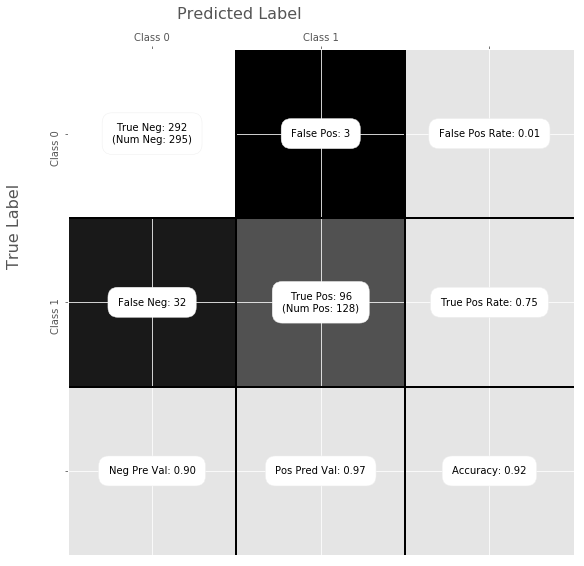

In [437]:
# pred = mv_clf.predict(X_test)
# predicted_mv_clf
from sklearn.metrics import confusion_matrix
from matplotlib.pylab import rcParams

C = confusion_matrix(y_test.values, predicted_mv_clf, labels=[0,1])
show_confusion_matrix(C, ['Class 0', 'Class 1']) 

In [438]:
print( df_bin.to_latex() )

\begin{tabular}{lllllllr}
\toprule
{} & Accuracy & Precision & Recall & f1-score & True Neg Rate & True Pos Rate &  Tuning Time \\
\midrule
Logistic Regression    &    91.5\% &     97.9\% &  73.4\% &    83.9\% &         99.3\% &         73.4\% &          100 \\
Logistic Regression FT &    91.0\% &     92.5\% &  76.6\% &    83.8\% &         97.3\% &         76.6\% &          100 \\
SVM                    &    69.7\% &      0.0\% &   0.0\% &     0.0\% &        100.0\% &          0.0\% &          100 \\
SVM FT                 &    90.8\% &     91.6\% &  76.6\% &    83.4\% &         96.9\% &         76.6\% &          100 \\
Decision Tree          &    88.7\% &     80.3\% &  82.8\% &    81.5\% &         91.2\% &         82.8\% &          100 \\
Decision Tree FT       &    90.3\% &     94.8\% &  71.9\% &    81.8\% &         98.3\% &         71.9\% &          100 \\
Naive Bayes            &    78.5\% &     97.4\% &  29.7\% &    45.5\% &         99.7\% &         29.7\% &          100 \\
Naive 

# Radar Chart

# Reference:

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, ngram_range = (1,3), 
                             stop_words = 'english', max_features = 500 )

In [109]:
clean_texts = list(df_copy['Clean Text'].astype(str))
features = vectorizer.fit_transform(clean_text)
features.shape

(1686, 500)

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( features, labels, stratify = labels,  
                                    random_state = 0, test_size = 0.25 )

In [183]:
# print(y_train[:5])
print(type(y_train))
print(y_train.count())
print(y_test.count())
print( 'Train Data: \n {}'.format(y_train.value_counts()) )
print('Test Data: \n', y_test.value_counts())

<class 'pandas.core.series.Series'>
1264
422
Train Data: 
 0    879
1    385
Name: Label, dtype: int64
Test Data: 
 0    294
1    128
Name: Label, dtype: int64


In [120]:
print(X_train[0])
y_train[0]

  (0, 343)	0.121886617659
  (0, 411)	0.0499905528336
  (0, 194)	0.0467524389135
  (0, 278)	0.0474697328404
  (0, 90)	0.301832523053
  (0, 210)	0.152862628975
  (0, 425)	0.0485735104576
  (0, 230)	0.0990589597121
  (0, 337)	0.19662026928
  (0, 201)	0.0433700166058
  (0, 499)	0.0893232445303
  (0, 338)	0.203486680238
  (0, 101)	0.0467524389135
  (0, 136)	0.0646297934223
  (0, 389)	0.356614603801
  (0, 193)	0.0422222733231
  (0, 6)	0.0470095990391
  (0, 89)	0.235201005869
  (0, 197)	0.0438956805584
  (0, 176)	0.0412865644706
  (0, 342)	0.447187224712
  (0, 195)	0.0478748534411
  (0, 198)	0.0373173284789
  (0, 226)	0.0916460390019
  (0, 332)	0.0386891043871
  :	:
  (0, 454)	0.0859395424531
  (0, 146)	0.116868858097
  (0, 254)	0.0482204010425
  (0, 121)	0.0329529945975
  (0, 102)	0.096788530743
  (0, 18)	0.11533805531
  (0, 145)	0.116269224351
  (0, 170)	0.0873667114017
  (0, 169)	0.0958867470572
  (0, 327)	0.0376767298914
  (0, 235)	0.0884980966079
  (0, 10)	0.0822115238953
  (0, 446)	0.03

1

In [135]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train.astype('category'))
predicted_NaiveBayes = nb.predict(X_test)

In [136]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train.astype('category'))
predicted_SVM = clf.predict(X_test)

In [137]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train.astype('category'))
predicted_DT = dt.predict(X_test)

In [131]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train.astype('category'))
predicted_neigh = neigh.predict(X_test)

In [159]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(X_train, y_train.astype('category'))
predicted_rf = rf.predict(X_test)

In [139]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lg.fit(X_train, y_train.astype('category'))
predicted_lg = lg.predict(X_test)

In [146]:
from sklearn.linear_model import LogisticRegressionCV
lgcv = LogisticRegressionCV()
lgcv.fit(X_train, y_train.astype('category'))
predicted_lgcv = lgcv.predict(X_test)

In [160]:
model_name =["NaiveBayes","SVM", 'DecisionTree', 'KNeighbors', 'RandomForest', 
           'LogisticRegression', 'LogisticRegressionCV']
predicted = [predicted_NaiveBayes, predicted_SVM, predicted_DT, predicted_neigh,
              predicted_rf, predicted_lg, predicted_lgcv ]

def percent_round(x):
    return(str((np.mean(x)*100).round(1))+"%")

acc = [percent_round(x==y_test) for x in predicted]
acc_list = {'Accuracy' : pd.Series(acc, index=model_name)}
df_acc = pd.DataFrame(acc_list)
df_acc

,Accuracy
NaiveBayes,87.7%
SVM,69.7%
DecisionTree,85.1%
KNeighbors,89.1%
RandomForest,87.7%
LogisticRegression,90.8%
LogisticRegressionCV,91.2%


In [161]:
predicted = [predicted_NaiveBayes, predicted_SVM, predicted_DT, predicted_neigh,
              predicted_rf, predicted_lg, predicted_lgcv ]
def percent_round(x):
    return(str((x*100).round(1))+ "%")

Accuracy = [percent_round(np.mean(x==y_test)) for x in predicted]
Report = [sklearn.metrics.precision_recall_fscore_support(y_test, x) for x in predicted]
Precision = [percent_round(x[0][1]) for x in Report]
Recall = [percent_round(x[1][1]) for x in Report]
f1score = [percent_round(x[2][1]) for x in Report]
result = {'Accuracy' : pd.Series(Accuracy, index=model_name),
           'Precision' : pd.Series(Precision, index=model_name),
           'Recall' : pd.Series(Recall, index=model_name),
           'f1-score': pd.Series(f1score, index=model_name),
           }
df_bin = pd.DataFrame(result)
df_bin

/Users/yuleinku/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1-score
NaiveBayes,87.7%,83.9%,73.4%,78.3%
SVM,69.7%,0.0%,0.0%,0.0%
DecisionTree,85.1%,75.6%,75.0%,75.3%
KNeighbors,89.1%,86.6%,75.8%,80.8%
RandomForest,87.7%,98.7%,60.2%,74.8%
LogisticRegression,90.8%,92.4%,75.8%,83.3%
LogisticRegressionCV,91.2%,93.3%,76.6%,84.1%


In [162]:
# print("Naive Bayes Performance \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes))
# print("SVM Performance \n",sklearn.metrics.classification_report(y_test, predicted_SVM))
# print("Decision Tree Performance \n",sklearn.metrics.classification_report(y_test, predicted_DT))
# print("KNeighbors Performance \n",sklearn.metrics.classification_report(y_test, predicted_neigh))
# print("RandomForest Performance \n",sklearn.metrics.classification_report(y_test, predicted_rf))
# print("LogisticRegression Performance \n",sklearn.metrics.classification_report(y_test, predicted_lg))
# print("LogisticRegressionCV \n",sklearn.metrics.classification_report(y_test, predicted_lgcv))

In [163]:
nb.fit(X_train, y_train)
probas_NaiveBayes = nb.predict_proba(X_test)[:,1]

clf.fit(X_train, y_train)
probas_SVM = nb.predict_proba(X_test)[:,1]

# dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
probas_DT = dt.predict_proba(X_test)[:,1]

# neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
probas_neigh = neigh.predict_proba(X_test)[:,1]

# rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
probas_rf = rf.predict_proba(X_test)[:,1]

# lg = LogisticRegression()
lg.fit(X_train, y_train)
probas_lg = lg.predict_proba(X_test)[:,1]

# lgcv = LogisticRegressionCV()
lgcv.fit(X_train, y_train)
probas_lgcv = lgcv.predict_proba(X_test)[:,1]

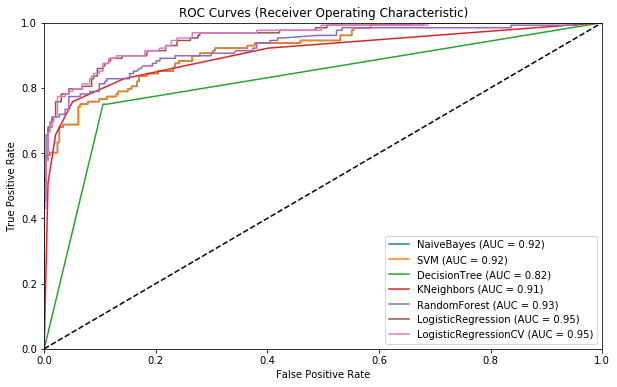

In [164]:
from sklearn.metrics import roc_curve, auc
matplotlib.rcParams['figure.figsize'] = (10, 6)

probas=[probas_NaiveBayes, probas_SVM, probas_DT, probas_neigh,
              probas_rf, probas_lg, probas_lgcv ]

fpr= [None] * len(probas)
tpr=[None] * len(probas)
thresholds=[None] * len(probas)
roc_auc=[None] * len(probas)
for i in range(len(probas)):
    fpr[i], tpr[i], thresholds[i] = sklearn.metrics.roc_curve(y_test.ravel().astype(float), probas[i], pos_label=1.0)
    roc_auc[i]=auc(fpr[i],tpr[i])
    plt.plot(fpr[i], tpr[i], label=model_name[i]+" (AUC = %0.2f)" % roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Receiver Operating Characteristic)')
plt.legend(loc="lower right")   

In [2]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded


def plotROC(y_test, y_proba, model_name):
    # Determine the false positive and true positive rates
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    # Calculate the AUC
    roc_auc = metrics.auc(fpr,tpr)
    print( 'auc: ', roc_auc )

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.title('ROC Curve (%s)' % model_name, fontsize=14)
    plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)'% roc_auc, linewidth=2)
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1],'r--', linewidth=2)
    # plt.xlim([-0.1,1.2])
    # plt.ylim([-0.1,1.2])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    # plt.savefig(model_name + '.png')
    # plt.show()


def plotROC_all_in_one(y_test, y_proba, model_name):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    roc_auc = metrics.auc(fpr,tpr)
    print( '################################# %s #################################\n' % (model_name) )
    print( 'AUC (%s): %0.5f' % (model_name,roc_auc) )
    plt.plot(fpr, tpr, color=next(colors), linestyle=next(linestyles), \
                label='ROC curve %s (area = %0.2f)'% (model_name,roc_auc), linewidth=2)
    # plt.plot(fpr, tpr, label='ROC curve %s (area = %0.2f)'% (model_name[0:5],roc_auc), linewidth=4)
    # plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% (roc_auc), linewidth=2)
    plt.legend(loc='lower right')


def plot_frame():
    # Plot of a ROC curve for a specific class
    # fig = plt.figure()
    plt.title('ROC Curve (All models)', fontsize=14)
    plt.plot([0, 1],[0, 1],'r--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    # Axes.set_default_color_cycle(['red', 'black', 'yellow'])
    # colors = cm.rainbow( np.linspace(0, 1, 2) )
    num_plot = 12
    colors = cm.rainbow( np.linspace(0, 1, num_plot) )
    colors = cycle(colors)
    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy'])
    linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted', '-', '--', '-.', ':'])
    # print colors
    # exit()
    return colors, linestyles


def roc_para(classifier, test_feats):
    y_test = []
    y_proba = []
    for t in test_feats:
        # print 't = ', t[1] 
        y_test.append(t[1])
        proba = classifier.prob_classify(t[0]).prob('pos')
        # print 'proba = ', proba
        y_proba.append( proba )

    y_test = coding(y_test, {'neg': 0, 'pos': 1})
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    return y_test, y_proba

## Cleaning and Preparing Text Data

## Building feature vectors from text documents

## Training machine learning models to classify positive and negative docs

In [16]:
'''
=================================
Data Corpus
=================================
'''

from nltk.corpus import movie_reviews
from nltk.classify import NaiveBayesClassifier

In [29]:
documents = [(list(movie_reviews.words(fileid)), category) 
             for category in movie_reviews.categories() 
             for fileid in movie_reviews.fileids(category)]

In [50]:
movie_reviews.categories()
# movie_reviews.fileids(category)
movie_reviews.fileids('neg')
print('Number of negative files ', len(movie_reviews.fileids('neg')))
print('Number of positive files  {}'.format(len(movie_reviews.fileids('pos'))) )
print(type(documents))
print(len(documents))
print(documents[0])
# print(documents[1])

Number of negative files  1173
Number of positive files  513
<class 'list'>
1686
(['A', 'B', 'S', 'T', 'R', 'A', 'C', 'T', 'Effects', 'of', 'two', 'tillage', 'treatments', ',', 'tillage', '(', 'T', ')', 'with', 'chisel', 'plough', 'and', 'no', '-', 'till', '(', 'NT', '),', 'were', 'studied', 'under', 'undrained', 'and', 'drained', 'soil', 'conditions', '.', 'Soil', 'physical', 'properties', 'measured', 'were', 'bulk', 'density', '(', 'rb', '),', 'total', 'porosity', '(', 't', '),', 'water', 'stable', 'aggregates', '(', 'WSA', '),', 'geometric', 'mean', 'diameter', '(', 'GMD', '),', 'mean', 'weight', 'diameter', '(', 'MWD', '),', 'organic', 'carbon', '(', 'OC', ')', 'and', 'total', 'N', 'concentrations', 'in', 'different', 'aggregate', 'size', 'fractions', ',', 'and', 'total', 'OC', 'and', 'N', 'pools', '.', 'The', 'experiment', 'was', 'established', 'in', '1994', 'on', 'a', 'poorly', 'drained', 'Crosby', 'silt', 'loam', 'soil', '(', 'fine', 'mixed', ',', 'mesic', ',', 'Aeric', 'Ochraqu

In [33]:
# clean_text(documents[0][0])
movie_reviews.fileids('neg')

['neg/001_abid&lal2008SoilTillRes.txt_1.txt',
 'neg/001_abid&lal2008SoilTillRes.txt_2.txt',
 'neg/001_abid&lal2008SoilTillRes.txt_4.txt',
 'neg/001_abid&lal2008SoilTillRes.txt_5.txt',
 'neg/001_abid&lal2008SoilTillRes.txt_6.txt',
 'neg/002_abu2013SoilResearch SA.txt_1.txt',
 'neg/002_abu2013SoilResearch SA.txt_2.txt',
 'neg/002_abu2013SoilResearch SA.txt_6.txt',
 'neg/003_acosta-martinez.etal2003BiolFertilSoils.txt_1.txt',
 'neg/003_acosta-martinez.etal2003BiolFertilSoils.txt_2.txt',
 'neg/003_acosta-martinez.etal2003BiolFertilSoils.txt_5.txt',
 'neg/003_acosta-martinez.etal2003BiolFertilSoils.txt_6.txt',
 'neg/004_acosta-martinez.etal2004SoilSciSocAmJ.txt_1.txt',
 'neg/004_acosta-martinez.etal2004SoilSciSocAmJ.txt_2.txt',
 'neg/004_acosta-martinez.etal2004SoilSciSocAmJ.txt_5.txt',
 'neg/004_acosta-martinez.etal2004SoilSciSocAmJ.txt_6.txt',
 'neg/005_acosta-martinez.etal2007ApplSoilEcol.txt_1.txt',
 'neg/005_acosta-martinez.etal2007ApplSoilEcol.txt_2.txt',
 'neg/005_acosta-martinez.eta

In [52]:
txt = movie_reviews.words('neg/001_abid&lal2008SoilTillRes.txt_1.txt')[:400]
txt = ' '.join(txt)
print( txt )
clean_text( txt )

A B S T R A C T Effects of two tillage treatments , tillage ( T ) with chisel plough and no - till ( NT ), were studied under undrained and drained soil conditions . Soil physical properties measured were bulk density ( rb ), total porosity ( t ), water stable aggregates ( WSA ), geometric mean diameter ( GMD ), mean weight diameter ( MWD ), organic carbon ( OC ) and total N concentrations in different aggregate size fractions , and total OC and N pools . The experiment was established in 1994 on a poorly drained Crosby silt loam soil ( fine mixed , mesic , Aeric Ochraqualf ) near Columbus , Ohio . In 2007 , soil samples were collected ( 0 - 10 , 10 - 20 , and 20 - 30 cm ) from all treatments and separated into six aggregate size classes for assessing proportions of macro ( 5 - 8 , 2 - 5 , 1 - 2 , 0 . 5 - 1 , 0 . 25 - 0 . 5 ) and micro (< 0 . 25 mm ) aggregates by wet sieving . Tillage treatments significantly ( P 0 . 05 ) influenced WSA , MWD , and GMD . Higher total WSA ( 78 . 53 vs 

/Users/yuleinku/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yuleinku/nltk_data/corpora/movie_reviews/neg/001_abid&lal2008SoilTillRes.txt_1.txt'>
  """Entry point for launching an IPython kernel.


'a b s t r a c t effects of two tillage treatments   tillage   t   with chisel plough and no   till   nt    were studied under undrained and drained soil conditions   soil physical properties measured were bulk density   rb    total porosity   t    water stable aggregates   wsa    geometric mean diameter   gmd    mean weight diameter   mwd    organic carbon   oc   and total n concentrations in different aggregate size fractions   and total oc and n pools   the experiment was established in      on a poorly drained crosby silt loam soil   fine mixed   mesic   aeric ochraqualf   near columbus   ohio   in        soil samples were collected                      and         cm   from all treatments and separated into six aggregate size classes for assessing proportions of macro                                                        and micro           mm   aggregates by wet sieving   tillage treatments significantly   p          influenced wsa   mwd   and gmd   higher total wsa           vs

In [5]:
lfeats = label_feats_from_corpus(movie_reviews)
train_feats, test_feats = split_label_feats(lfeats, split=0.75)

print( movie_reviews.categories() )
print( lfeats.keys() )
print( 'Training files: ', len(train_feats) )
print( 'Testing files: ', len(test_feats) )
print( 'Total files: ', len(train_feats)+len(test_feats) )

print( 'train_feats: ', train_feats[0] )
fig = plt.figure()
# colors, linestyles = plot_frame()

['neg', 'pos']
dict_keys(['neg', 'pos'])
Training files:  1263
Testing files:  423
Total files:  1686
train_feats:  ({'A': True, 'B': True, 'S': True, 'T': True, 'R': True, 'C': True, 'Effects': True, 'of': True, 'two': True, 'tillage': True, 'treatments': True, ',': True, '(': True, ')': True, 'with': True, 'chisel': True, 'plough': True, 'and': True, 'no': True, '-': True, 'till': True, 'NT': True, '),': True, 'were': True, 'studied': True, 'under': True, 'undrained': True, 'drained': True, 'soil': True, 'conditions': True, '.': True, 'Soil': True, 'physical': True, 'properties': True, 'measured': True, 'bulk': True, 'density': True, 'rb': True, 'total': True, 'porosity': True, 't': True, 'water': True, 'stable': True, 'aggregates': True, 'WSA': True, 'geometric': True, 'mean': True, 'diameter': True, 'GMD': True, 'weight': True, 'MWD': True, 'organic': True, 'carbon': True, 'OC': True, 'N': True, 'concentrations': True, 'in': True, 'different': True, 'aggregate': True, 'size': True,

In [15]:
# vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, ngram_range = (1,3), 
#                              stop_words = 'english', max_features = 500 )

# # Extract features from reviewText for X
# corpus_reviewText=list(data["reviewText"].astype(str))
# X_tfidf_reviewText = vectorizer.fit_transform(corpus_reviewText)
# X_tfidf_reviewText.shape
lfeats.keys()
print( lfeats.keys() )

dict_keys(['neg', 'pos', 0])


################################# nb_classifier #################################

AUC (nb_classifier): 0.92263
Accuracy:  0.8085106382978723
Time Taken :  4.079028


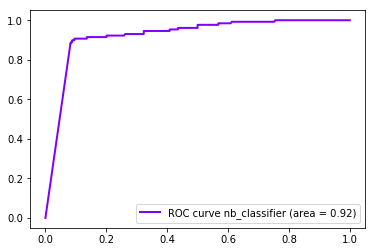

In [4]:
'''
=================================
Training a Naive Bayes Classifier
=================================
'''

t_start = time.clock()
nb_classifier = NaiveBayesClassifier.train(train_feats)
y_test, y_proba = roc_para(nb_classifier, test_feats)
model_name = 'nb_classifier'
plotROC_all_in_one(y_test, y_proba, model_name)
# plotROC(y_test, y_proba, 'model_name')
print( 'Accuracy: ', accuracy(nb_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

DT :  0.7966903073286052
Time Taken :  155.010123
################################# DecisionTreeClassifier #################################

AUC (DecisionTreeClassifier): 0.85147
Accuracy:  0.8628841607565012
Time Taken :  1.4313569999999913


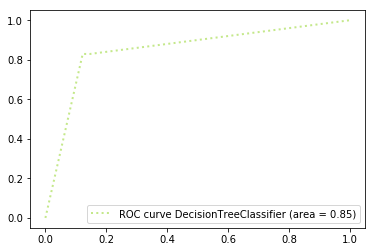

In [19]:
'''
===================================
Training a Decision Tree Classifier
===================================
'''

from nltk.classify import DecisionTreeClassifier as DT
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from nltk.probability import FreqDist, MLEProbDist, entropy

t_start = time.clock()
dt_classifier = DT.train(train_feats, binary=True, entropy_cutoff=0.8, depth_cutoff=5, support_cutoff=30) 
print( 'DT : ', accuracy(dt_classifier, test_feats) )
# y_test, y_proba = roc_para(dt_classifier, test_feats)
# model_name = 'DecisionTreeClassifier'
# plotROC_all_in_one(y_test, y_proba, model_name)
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )


from sklearn.tree import DecisionTreeClassifier

t_start = time.clock()
dt_classifier = SklearnClassifier(DecisionTreeClassifier()).train(train_feats)

y_test, y_proba = roc_para(dt_classifier, test_feats)
model_name = 'DecisionTreeClassifier'
plotROC_all_in_one(y_test, y_proba, model_name)
print( 'Accuracy: ', accuracy(dt_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

################################# MaxentClassifier GIS #################################

AUC (MaxentClassifier GIS): 0.81579
Accuracy:  0.7399527186761229
Time Taken :  7.915031000000003


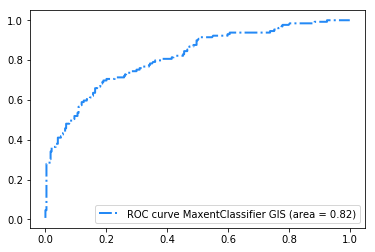

In [7]:
'''
=====================================
Training a Maximum Entropy Classifier
=====================================
'''
from nltk.classify import MaxentClassifier

# t_start = time.clock()
# me_classifier = MaxentClassifier.train(train_feats, trace=0, max_iter=1, min_lldelta=0.5)

# y_test, y_proba = roc_para(me_classifier, test_feats)
# model_name = 'MaxentClassifier'
# plotROC_all_in_one(y_test, y_proba, model_name)
# print 'Accuracy: ', accuracy(me_classifier, test_feats)
# t_end = time.clock()
# print 'Time Taken : ', t_end - t_start


t_start = time.clock()
me_classifier = MaxentClassifier.train(train_feats, algorithm='gis', trace=0, max_iter=10, min_lldelta=0.5)

y_test, y_proba = roc_para(me_classifier, test_feats)
model_name = 'MaxentClassifier GIS'
plotROC_all_in_one(y_test, y_proba, model_name)
print( 'Accuracy: ', accuracy(me_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

################################# LogisticRegression #################################

AUC (LogisticRegression): 0.96165
Accuracy:  0.9361702127659575
Time Taken :  1.1818890000000017


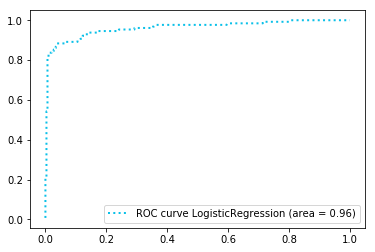

In [10]:
from sklearn.linear_model import LogisticRegression

t_start = time.clock()
sk_classifier = SklearnClassifier(LogisticRegression()).train(train_feats)

y_test, y_proba = roc_para(sk_classifier, test_feats)
model_name = 'LogisticRegression'
plotROC_all_in_one(y_test, y_proba, model_name)
print( 'Accuracy: ', accuracy(sk_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

################################# RandomForestClassifier #################################

AUC (RandomForestClassifier): 0.95881
Accuracy:  0.9385342789598109
Time Taken :  8.443363000000005


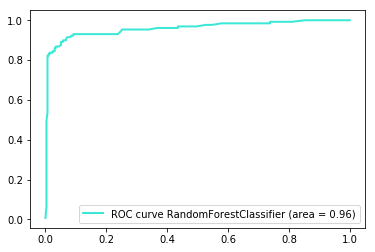

In [11]:
from sklearn.ensemble import RandomForestClassifier

t_start = time.clock()
rfc_classifier = SklearnClassifier(RandomForestClassifier(n_estimators=100)).train(train_feats)

y_test, y_proba = roc_para(rfc_classifier, test_feats)
model_name = 'RandomForestClassifier'
plotROC_all_in_one(y_test, y_proba, model_name)
print( 'Accuracy: ', accuracy(rfc_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

################################# LinearRegression #################################

AUC (LinearRegression): 0.96165
Accuracy:  0.9361702127659575
Time Taken :  1.2142040000000023


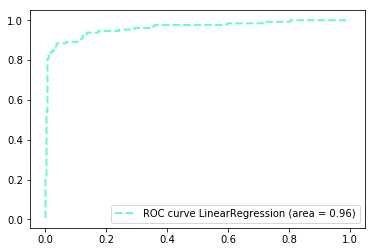

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifierCV, LogisticRegressionCV, ElasticNet

t_start = time.clock()
lr_classifier = SklearnClassifier(LogisticRegression(penalty='l2')).train(train_feats)
y_test, y_proba = roc_para(lr_classifier, test_feats)
model_name = 'LinearRegression'
plotROC_all_in_one(y_test, y_proba, model_name)
print( 'Accuracy: ', accuracy(lr_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

################################# LinearRegression #################################

AUC (LinearRegression): 0.96695
Accuracy:  0.9361702127659575
Time Taken :  1.1636639999999971


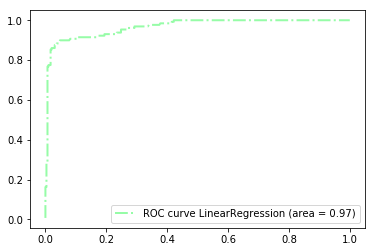

In [15]:
t_start = time.clock()
lr_classifier = SklearnClassifier(LogisticRegression(penalty='l1')).train(train_feats)
y_test, y_proba = roc_para(lr_classifier, test_feats)
model_name = 'LinearRegression'
plotROC_all_in_one(y_test, y_proba, model_name)
print( 'Accuracy: ', accuracy(lr_classifier, test_feats) )
t_end = time.clock()
print( 'Time Taken : ', t_end - t_start )

In [18]:
# import xgboost as xgb

# t_start = time.clock()
# bst_classifier = SklearnClassifier( xgb.XGBClassifier(max_depth = 5,  learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic') ).train(train_feats)
# y_test, y_proba = roc_para(bst_classifier, test_feats)
# model_name = 'XGBoost'
# plotROC_all_in_one(y_test, y_proba, model_name)
# print( 'Accuracy: ', accuracy(bst_classifier, test_feats) )
# t_end = time.clock()
# print( 'Time Taken : ', t_end - t_start )